In [1]:
import os
import re
from airtable import Airtable
import requests
import pandas as pd
import datetime
import numpy as np
import random
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import squarify
import plotly.express as px
import plotly.graph_objects as go

## 1- Connect to airtable

In [ ]:
import pandas as pd
from airtable import Airtable

api_key = 'patngX23FWWWnl2iH.e5c8bc51522c7d6db26f4668e80775aa7f344107ec6a1204a5b388427a6e1da7'
base_id = 'appfjmrH6l5m4Z82K'
table_name_mapping = {
    'tblM34kdan10sEZrK': 'items',
    'tblSYZrSYVQJcvNkR': 'customers',
    'tblkGA9TFjiGyiqTN': 'payments',
    'tblm5kBGMQg08mIej': 'suppliers',
    'tblFuLuXFBtrqHbe3': 'catalog',
    'tbly4c5vUFLAP91ga': 'orders'
}

def fetch_all_airtable_data(api_key, base_id, table_name_mapping):
    all_dataframes = {}
    for table_id, table_name in table_name_mapping.items():
        airtable = Airtable(base_id, table_id, api_key)
        records = []
        for record in airtable.get_all():
            records.append(record['fields'])
        df = pd.DataFrame.from_records(records)
        all_dataframes[table_name] = df
        df.to_csv(f'{table_name}.csv', index=False)
    return all_dataframes

In [ ]:
fetch_all_airtable_data(api_key, base_id, table_name_mapping)

## 1bis - Cleaning before merging

### orders and payments

In [ ]:
#merging orders with payments

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
orders = pd.read_csv('orders.csv')
pay = pd.read_csv('payments.csv')

In [ ]:
def clean_a():
    # Use a regular expression to extract digits or NaN
    orders['Num (from Customer)'] = orders['Num (from Customer)'].str.extract(r"(\d+|\d+\.\d+|\d+\.\d+e\+\d+|\d+\.\d+e-\d+|\d+e\+\d+|\d+e-\d+|\d+\.\d+e-\d+|\d+\.\d+e\+\d+|NaN)", expand=False)
    # Convert the 'Extracted_Num' column to numeric (handles NaN)
    orders['Num (from Customer)'] = pd.to_numeric(orders['Num (from Customer)'], errors='coerce')
    orders['Num (from Customer)'] = orders['Num (from Customer)'].astype(pd.Int64Dtype(), errors='ignore')
    orders['Order num'] =pd.to_numeric(orders['Order num'], errors='coerce').astype('float64')
    orders.dropna(subset=['Num (from Customer)'], inplace=True)
    # Use a regular expression to extract digits or NaN
    pay['Num (from Customer)'] = pay['Num (from Customer)'].str.extract(r"(\d+|\d+\.\d+|\d+\.\d+e\+\d+|\d+\.\d+e-\d+|\d+e\+\d+|\d+e-\d+|\d+\.\d+e-\d+|\d+\.\d+e\+\d+|NaN)", expand=False)
    # Convert the 'Extracted_Num' column to numeric (handles NaN)
    pay['Num (from Customer)'] = pd.to_numeric(pay['Num (from Customer)'], errors='coerce')
    pay['Num (from Customer)'] = pay['Num (from Customer)'].astype(pd.Int64Dtype(), errors='ignore')
    pay.sort_values(by=['Num (from Customer)', 'Order # (from Orders)', 'Requested on'], ascending=[True, True, True], inplace=True)
    pay.drop_duplicates(subset=['Num (from Customer)', 'Order # (from Orders)'], keep='last', inplace=True)
    pay['Order # (from Orders)'] =pd.to_numeric(pay['Order # (from Orders)'], errors='coerce').astype('float64')
    
    orders.sort_values(by=['Num (from Customer)', '#', 'Order num','Invoice #'], ascending=[True, True, True, True], inplace=True)

In [ ]:
clean_a()

In [ ]:
dfa = pd.merge(orders, pay, how='left', left_on=['Num (from Customer)', 'Order num'], right_on=['Num (from Customer)', 'Order # (from Orders)'])
dfa.sample()

In [ ]:
dfa.to_csv("orderspayments.csv")

### Orders with customers

In [ ]:
#merging orderspayments with customers

In [ ]:
ord = pd.read_csv('orderspayments.csv')
cust = pd.read_csv('customers.csv')

In [ ]:
def clean_b():
    cust['Num'] = pd.to_numeric(cust['Num'], errors='coerce').astype('Int64')
    cust.dropna(subset=['Name'], inplace=True)
    cust.dropna(subset=['Num'], inplace=True)

In [ ]:
clean_b()

In [ ]:
dfa2 = pd.merge(ord, cust, how='outer', left_on='Num (from Customer)', right_on='Num')
dfa2.sample()

In [ ]:
# Fill NaN values in 'Num (from Customer)' with values from 'Num'
dfa2['Num (from Customer)'].fillna(dfa2['Num'], inplace=True)
dfa2['Name (from Customer)'].fillna(dfa2['Name'], inplace=True)
dfa2['Invoicing address (from Customer)_x'].fillna(dfa2['Invoicing address'], inplace=True)
dfa2['Project name'].fillna(dfa2['Project name (from Orders)'], inplace=True)
dfa2['Project name (from Orders)'].fillna(dfa2['Project name'], inplace=True)
dfa2.drop_duplicates(subset=['Num (from Customer)', 'Order num', 'Project name'], keep='last', inplace=True)
dfa2.drop_duplicates(subset=['Num (from Customer)','Email (from Manager)','Order total','Created: project name','Date quote sent'], keep='last', inplace=True)
    

In [ ]:
to_drop = ['Manager_x','Today_x','Teams (from Manager)',
           'Team Emails (from Managers) (from Teams) (from Manager)_x',
          'Customer_x','DELETE invoice total','Year','Invoicing contact (from Customer)_x',
           'Invoice button','Items Table_Id','Customer Table_Id',
           'Open URL','Order items Table_Id','Payments Table_Id',
          'Order to supplier Table_Id','Create quote','Payments_button','Paper track',
           'Button quote','Empty order items alert','Check order number',
          'Prod and ship','Ship addresses missing (from Customer)','Create BAT',
          'Check signed BAT','Create mold invoice','Create cost PDF','Alert mold invoice sent',
          'Alert MP invoice payment','Create supplier contract', 'Alert sample approval',
          'Manage invoices', 'Update Customer info','Sample order','MP order',
          '#','Invoice #','Customer name in text', 
            'Quantity (from Shipments) (from Order items)','Remains to be shipped (from Order items)','Invoicing address','Invoice Ref',
            'Customer name in text','Manage BAT','Total on invoice', 'Balance due on invoice',
            'Email (from Invoicing contact) (from Customer)_x','Addresses missing (from Customer)',
            'Today plus 7','Days RS', 'Days since R','Paid for MP downpayment',
            'Paid for MP','Percentage paid','Order items','Total (from Order items)',
            'On invoice (from Order items)','Order unit cost ¥ (from Order items)',
           'Cost check (from Order items)','Price check (from Order items)','Total price on invoice (from Order items)',
            'Total price mold invoice (from Order items)','Picture (from Order items)',
            'Customer contact','Quote PDF','Project type','Payments_x',
            'Amount paid (from Invoices)','Status of payment (from Payments)',
            'Picture for this order (from Order items)','Picture for this order (from Order items) 2',
                        'Status mold payment (from Payments)','Status MP downpayment (from Payments)',
                        'Order photo (from Order items)','Order type',
           'Payments to suppliers','Payment date (from Payments to suppliers)','Supplier (from Payments to suppliers)',
                        'Percentage of downpayment','Balance due time','BAT',
                        'Order to supplier','Inner size','Mold invoice issued on','Mold invoice','Stage (from Payments)',
                        'Shipments (from Order items)','Customer Payment #','Customer_y','Stage','Payments_y','Days to payment due',
                        'Status of payment','Status MP downpayment','Num of days','Warning','Invoicing contact (from Customer)_y',
                        'Invoicing address (from Customer)_y','Email (from Invoicing contact) (from Customer)_y',
                        'Today_y','Invoiced vs. paid','Invoice total (from Orders)','% asked (auto)',
                        'Total cost (from Order items) (from Orders)','¥ due to supplier','Supplier payment status',
                        'Paid to supplier','Wire transfer date (July)','Wire transfer amount','Orders_x',
                        'Order # (from Orders)','Name (from Customer) (from Orders)','Manager (from Orders)',
                        'Order items (from Orders)','View invoice (from Orders)','Supplier payment date (July)','Special discount (from Orders)',
           'Sales Rep','Contacts','Num','Name','Client','Status_y',
            'Lifetime value','Email (from Invoicing contact)','Invoicing address','Email (from Sales Rep)',
            'Count (Addresses) invoice','Inv addresses missing','Count (Addresses) ship','Ship addresses missing',
            'Count contacts','Contact missing','Email (from Contacts)','Update customer info','Orders_y',
            'Total paid (from Orders)','Manager_y','Team Emails (from Managers) (from Teams) (from Manager)_y',
            'Catalogue','Order status (from Orders)','Shipping addresses', 'Shipping address_y','Other names',
           'Payment requests INV','Website','Addresses','Priority','Type (from Addresses)','Products','Invoice Street name and num (from Addresses)',
            'Invoice City and Zipcode (from Addresses)','Invoice Country (from Addresses)',
          'Container Shipping address #2','Accounting contact Name (from Contacts)','Tax ID / DVT / RFC',
           'Artwork contact Name (from Contacts)','Phone','Quotes','Logistics contact Name (from Contacts)',
           'First contact','Last modified time of first contact']
dfa2.drop(columns=to_drop, inplace=True)

In [ ]:
dfa2.to_csv("orderspaymentscust.csv", index=False)

### Orders with items

In [ ]:
#merging orderspayments with customers

In [ ]:
ord = pd.read_csv('orderspaymentscust.csv')
it = pd.read_csv('items.csv')

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
len(it), 

In [ ]:
it.sample(1)

In [ ]:
it['Order # (from Orders)'] = it['Order # (from Orders)'].astype(str).apply(lambda x: re.sub(r'[^\d"]', '', x))

In [ ]:
it['Order # (from Orders)'].nunique()

In [ ]:
it['Progress'].value_counts()

In [ ]:
it = it.sort_values(by=['Order # (from Orders)', 'Progress'])
len(it)

In [ ]:
ord.sample(1)

In [ ]:
all_present = ord['Order num'].isin(it['Order # (from Orders)']).all()
all_present

In [ ]:
orders_not_in_items = ord[~ord['Order num'].isin(it['Order # (from Orders)'])]
# orders_not_in_items

In [ ]:
in_item_not_in_ord = it['Order # (from Orders)'].isin(ord['Order num']).all()
in_item_not_in_ord

In [ ]:
items_not_in_orders = it[~it['Order # (from Orders)'].isin(ord['Order num'])]

In [ ]:
#items_not_in_orders

In [ ]:
ord['Order num'].dtypes, it['Order # (from Orders)'].dtypes,len(it), len(ord)

In [ ]:
ord['Order num'].nunique(), it['Order # (from Orders)'].nunique()

In [ ]:
ord['Order num'].unique(), it['Order # (from Orders)'].unique()

In [ ]:
ord['Order num'].dtypes, it['Order # (from Orders)'].dtypes

In [ ]:
ord['Order num'] = ord['Order num'].astype('str') 
it['Order # (from Orders)']=it['Order # (from Orders)'].astype('str')

In [ ]:
# Convert to integers
ord['Order num'] = pd.to_numeric(ord['Order num'], errors='coerce').astype('Int64')
it['Order # (from Orders)'] = pd.to_numeric(it['Order # (from Orders)'], errors='coerce').astype('Int64')

In [ ]:
ord['Order num'].unique(), it['Order # (from Orders)'].unique()

In [ ]:
#merging orders with cust

In [ ]:
all_present = ord['Order num'].isin(it['Order # (from Orders)']).all()
all_present

In [ ]:
not_in_df1 = ord[~ord['Order num'].isin(it['Order # (from Orders)'])]['Order num'].unique()
not_in_df1

In [ ]:
not_in_df = it[~it['Order # (from Orders)'].isin(ord['Order num'])]['Order # (from Orders)'].unique()
not_in_df

In [ ]:
#cust = cust[~cust['Num'].duplicated(keep='first')]

In [ ]:
dfa3 = pd.merge(ord, it, how='left', left_on='Order num', right_on='Order # (from Orders)', suffixes=('_orde', '_items'))
dfa3.sample()

In [ ]:
len(dfa3)

In [ ]:
dfa2.to_csv("orderspaymentscustitems.csv")

## 2.1- Exploration

In [ ]:
# import autoviz
# %matplotlib inline

In [ ]:
# from autoviz.AutoViz_Class import AutoViz_Class
# AV = AutoViz_Class()
# filename = "orderspaymentscustitems.csv"
# dft = AV.AutoViz(filename)

In [ ]:
# from autoviz import AutoViz_Class
# #no target variable
# AV = AutoViz_Class()
# filename = "data.csv"
# dft = AV.AutoViz(
#     "",
#     sep=",",
#     depVar="",
#     dfte=df,
#     header=0,
#     verbose=1,
#     lowess=False,
#     chart_format="svg",
#     max_rows_analyzed=150000,
#     max_cols_analyzed=30,
#     save_plot_dir=None
# )

In [ ]:
# from autoviz import data_cleaning_suggestions
# data_cleaning_suggestions(df)

In [ ]:
# from autoviz import FixDQ
# fdq = FixDQ(quantile = 0.85)
# fdq.fit_transform(df).head()

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 9999)
df = pd.read_csv("orderspaymentscust.csv")

In [ ]:
df.sample()

In [ ]:
# !pip install ydata-profiling

In [ ]:
# from ydata_profiling import ProfileReport

# # Produce and save the profiling report
# profile = ProfileReport(df,title="Rock Profile Report")
# profile.to_file("ProfileReport.html")

In [ ]:
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
# pd.set_option('display.width', 9999)
df.info()

## 2.2- Cleaning and Preprocessing

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 9999)
df = pd.read_csv("orderspaymentscust.csv")

In [3]:
df.sample(4)

Unnamed: 0  Order num      Quote status         Name (from Customer)  Order total  Total paid  Balance due                               Email (from Manager) Sales Rep (from Customer)  Num (from Customer) Invoicing address (from Customer)_x  Quantity (from Order items) Status (from Customer)     Created: project name  Total cost (from Order items)  Total paid to suppliers  Total due to suppliers  Balance due to suppliers Last updated  Unit price $ (from Order items)  Item description (from Order items) Total cost (from Order items) 2                                           Overview Email (from Contacts) (from Customer)  Total mold invoice  Balance due on mold                                   Alert quote time            Contact missing (from Customer)  Paid for mold                                         View quote               Update customer info (from Customer)                                  Supplier Overview                                  Supplier payments                                          Shipments                       Alert do not pay supplier                        Alert payment to supplier 2                          Check ready date ETD (from Shipments (containers)) (from Order items) 2         Diff today ready                  Alert ETD order                                         All orders                                 Balance & shipment              Team lead (from Teams) (from Manager) Email (from Team lead) (from Teams) (from Manager)  Order date Type (from Order items)                Types  Total shipped (from Order items)  Remains to be shipped          Auto status  Shipment status       Payment status  Paid for Sample full payment  Downpayment needed check Order status                                        Invoice PDF Internal Rockwood comments Amount paid (from Payments to suppliers) Email (from Sales Rep) (from Customer)                               Project name Picture (from Catalogue item) (from Order items) Supplier (from Order items) Estimated ready date Customer complaint / claim Status (from Sales Rep) (from Customer) Balance payment paid Manager (from Order) (from Payments to suppliers) Company name (from Supplier) (from Payments to suppliers)             Sales Reps Invoice date Customer PO number Ship by         Email (from Sales Reps) Upload supplier invoice Date quote accepted Date quote requested Date quote created                                      Supplier cost Material (from Order items) Date mold invoice sent Signed BAT Shipments (containers) (from Order items) ETD (from Shipments (containers)) (from Order items) Order special requirements Date quote sent Alert payment to supplier Project documents  Special discount  Commission Commission paid on Supplier quote requested Invoices  Please pay New or repeat Sample approval Final balance due Product details Shipment details Shipping address on invoice Shipping address_x Country (from Shipping address) City and Zipcode (from Shipping address) Street name and num (from Shipping address) Type (from Shipping address) Order cancelled other date  Amount due Requested on Payment due date Order total (from Orders) Quantity (from Shipments) (from Order items) (from Orders) Balance due (from Orders) Email (from Manager) (from Orders)                 Project name (from Orders)  Num of days until due date Status_x  Payment due in a week  View invoice Status (from Sales Rep) Shipping Country (from Addresses) Shipping City and Zipcode (from Addresses) Shipping Street name and num (from Addresses) Purchasing contact Name (from Contacts) First order
685         NaN        NaN               NaN           Mcgowan rutherford          NaN         NaN          NaN                                                NaN                       NaN                 76.0                                , ,                           NaN                    NaN                       NaN                            NaN                      NaN                  

In [4]:
import interpreter

C:\Users\Tis\Documents\Test\Projects\Python\DB\dbrockwood\Lib\site-packages\blessed\terminal.py:183: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


In [5]:
# interpreter.chat("create a churn column from the dataset") # Executes a single command
# interpreter.chat()

In [6]:
if 'Project name (from Orders)' in df.columns:
    df = df.sort_values(by=['Num (from Customer)', 'Order num', 'Project name', 'Project name (from Orders)', 'Created: project name'], ascending=[True, True, True, True, True])
else:
    df = df.sort_values(by=['Num (from Customer)', 'Order num', 'Project name', 'Created: project name'], ascending=[True, True, True, True])


In [7]:
df = df.reset_index(drop=True)
df[38:40]

Unnamed: 0  Order num      Quote status      Name (from Customer)  Order total  Total paid  Balance due                               Email (from Manager) Sales Rep (from Customer)  Num (from Customer)                Invoicing address (from Customer)_x  Quantity (from Order items) Status (from Customer)     Created: project name  Total cost (from Order items)  Total paid to suppliers  Total due to suppliers  Balance due to suppliers Last updated  Unit price $ (from Order items)                Item description (from Order items)                    Total cost (from Order items) 2                                           Overview              Email (from Contacts) (from Customer)  Total mold invoice  Balance due on mold                                   Alert quote time Contact missing (from Customer)  Paid for mold                                         View quote               Update customer info (from Customer)                                  Supplier Overview                                  Supplier payments                                          Shipments Alert do not pay supplier Alert payment to supplier 2                               Check ready date ETD (from Shipments (containers)) (from Order items) 2         Diff today ready                                    Alert ETD order                                         All orders           Balance & shipment              Team lead (from Teams) (from Manager) Email (from Team lead) (from Teams) (from Manager)  Order date                            Type (from Order items)                                         Types  Total shipped (from Order items)  Remains to be shipped Auto status  Shipment status   Payment status  Paid for Sample full payment  Downpayment needed check Order status                                        Invoice PDF                         Internal Rockwood comments Amount paid (from Payments to suppliers) Email (from Sales Rep) (from Customer)                                       Project name   Picture (from Catalogue item) (from Order items)                        Supplier (from Order items) Estimated ready date Customer complaint / claim Status (from Sales Rep) (from Customer) Balance payment paid  Manager (from Order) (from Payments to suppliers) Company name (from Supplier) (from Payments to suppliers)             Sales Reps Invoice date Customer PO number Ship by       Email (from Sales Reps)                            Upload supplier invoice Date quote accepted Date quote requested Date quote created                                      Supplier cost Material (from Order items) Date mold invoice sent                                         Signed BAT Shipments (containers) (from Order items) ETD (from Shipments (containers)) (from Order items) Order special requirements Date quote sent Alert payment to supplier Project documents  Special discount  Commission Commission paid on Supplier quote requested Invoices  Please pay New or repeat Sample approval Final balance due Product details Shipment details Shipping address on invoice Shipping address_x Country (from Shipping address) City and Zipcode (from Shipping address) Street name and num (from Shipping address) Type (from Shipping address) Order cancelled other date  Amount due Requested on Payment due date Order total (from Orders) Quantity (from Shipments) (from Order items) (from Orders) Balance due (from Orders) Email (from Manager) (from Orders)                         Project name (from Orders)  Num of days until due date Status_x  Payment due in a week  View invoice Status (from Sales Rep) Shipping Country (from Addresses) Shipping City and Zipcode (from Addresses) Shipping Street name and num (from Addresses)       Purchasing contact Name (from Contacts) First order
38       126.0      341.0  Feedback pending  ['Aiko Importers, Inc.']      46612.8     23271.4      23341.4                     ['jennifer@rockwoodchina.com']     ['recf7VFVFSeyapEr0']                  1.0  ['225 Henry

In [8]:
duplicates = df[df.duplicated(subset=['Num (from Customer)','Order num','Project name'], keep=False)]
duplicates['Email (from Manager)'].value_counts(normalize=True)

Series([], Name: proportion, dtype: float64)

In [9]:
df.drop_duplicates(subset=['Num (from Customer)', 'Order num', 'Project name'], keep='last', inplace=True)

In [10]:
duplicates = df[df.duplicated(subset=['Num (from Customer)','Email (from Manager)','Order total','Created: project name','Date quote sent'], keep=False)]


In [11]:
df.drop_duplicates(subset=['Num (from Customer)','Email (from Manager)','Order total','Created: project name','Date quote sent'], keep='last', inplace=True)

In [12]:
df['Created: project name'].dtypes,df['Date quote requested'].dtypes,df['Date quote created'].dtypes

(dtype('O'), dtype('O'), dtype('O'))

In [13]:
# Replace the ' 's with NaN
df = df.replace(" ", np.NaN)

# Convert columns to numeric, preserving integer and float types
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Count the number of NaNs in the dataset to verify
print(df.isnull().values.sum())

# Show rows where at least 1 NaN exists
df[df.isnull().any(axis=1)].sample()

75867


Unnamed: 0  Order num Quote status      Name (from Customer)  Order total  Total paid  Balance due Email (from Manager) Sales Rep (from Customer)  Num (from Customer) Invoicing address (from Customer)_x  Quantity (from Order items) Status (from Customer) Created: project name  Total cost (from Order items)  Total paid to suppliers  Total due to suppliers  Balance due to suppliers Last updated  Unit price $ (from Order items) Item description (from Order items) Total cost (from Order items) 2 Overview Email (from Contacts) (from Customer)  Total mold invoice  Balance due on mold Alert quote time Contact missing (from Customer)  Paid for mold View quote Update customer info (from Customer) Supplier Overview Supplier payments Shipments Alert do not pay supplier Alert payment to supplier 2 Check ready date ETD (from Shipments (containers)) (from Order items) 2 Diff today ready Alert ETD order All orders Balance & shipment Team lead (from Teams) (from Manager) Email (from Team lead) (from Teams) (from Manager) Order date Type (from Order items) Types  Total shipped (from Order items)  Remains to be shipped Auto status Shipment status Payment status  Paid for Sample full payment  Downpayment needed check Order status Invoice PDF Internal Rockwood comments Amount paid (from Payments to suppliers) Email (from Sales Rep) (from Customer) Project name Picture (from Catalogue item) (from Order items) Supplier (from Order items) Estimated ready date Customer complaint / claim Status (from Sales Rep) (from Customer) Balance payment paid Manager (from Order) (from Payments to suppliers) Company name (from Supplier) (from Payments to suppliers) Sales Reps Invoice date Customer PO number Ship by Email (from Sales Reps) Upload supplier invoice Date quote accepted Date quote requested Date quote created Supplier cost Material (from Order items) Date mold invoice sent Signed BAT Shipments (containers) (from Order items) ETD (from Shipments (containers)) (from Order items) Order special requirements Date quote sent Alert payment to supplier Project documents  Special discount  Commission Commission paid on Supplier quote requested Invoices  Please pay New or repeat Sample approval Final balance due Product details Shipment details Shipping address on invoice Shipping address_x Country (from Shipping address) City and Zipcode (from Shipping address) Street name and num (from Shipping address) Type (from Shipping address) Order cancelled other date  Amount due Requested on Payment due date Order total (from Orders) Quantity (from Shipments) (from Order items) (from Orders) Balance due (from Orders) Email (from Manager) (from Orders) Project name (from Orders)  Num of days until due date Status_x  Payment due in a week  View invoice Status (from Sales Rep) Shipping Country (from Addresses) Shipping City and Zipcode (from Addresses) Shipping Street name and num (from Addresses) Purchasing contact Name (from Contacts) First order
601         NaN        NaN          NaN  LARK DISTILLERY PTY LTD           NaN         NaN          NaN                  NaN                       NaN                575.0                                , ,                           NaN                    NaN                   NaN                            NaN                      NaN                     NaN                       NaN          NaN                              NaN                                 NaN                             NaN      NaN                                   NaN                 NaN                  NaN              NaN                             NaN            NaN        NaN                                  NaN               NaN               NaN       NaN                       NaN                         NaN              NaN                                                NaN                  NaN             NaN        NaN                NaN                                   NaN                                                NaN        NaN      

In [15]:
#data preproc
#df['Project name (from Orders)'].fillna(df['Project name'], inplace=True)
df['Project name'] = df['Project name'].fillna('Unknown')
df['Name (from Customer)'] = df['Name (from Customer)'].astype(str).str.replace(r'\d+', '', regex=True).str.replace('[^a-zA-Z0-9]', ' ', regex=True).str.title().str.strip()
df['Num (from Customer)'] = df['Num (from Customer)'].apply(lambda x: int(''.join(filter(str.isdigit, str(x).replace('[', '').replace(']', '')))) if pd.notna(x) else np.nan)
df['Bottle Type'] = df['Item description (from Order items)'].apply(lambda x: re.findall(r'[a-zA-Z]+', x.split('-')[0])[0] if isinstance(x, str) and '-' in x else 'N/A')
# df['Bottle Type'] = df['Item description (from Order items)'].apply(lambda x: re.findall(r'[a-zA-Z]+', x.split('-')[0])[0] if isinstance(x, str) and '-' in x else None)
# df['Bottle Type'].fillna('N/A', inplace=True)
df['Bundle Bottle'] = df['Item description (from Order items)'].str.extract(r'(\w+ bottle)')
df['Amount Unpaid'] = df['Total paid'] - df['Order total']
df['Balance due quartile desc'] = pd.qcut(df['Balance due'], q=4, labels=['3', '2', '1'], duplicates='drop')
#df['Balance due quartile desc'] = pd.qcut(df['Balance due'], q=4, labels=['4', '3', '2', '1'])
df['Number of Purchases'] = df.groupby('Num (from Customer)')['Num (from Customer)'].transform('count')
df['Client Type'] = np.where(df['Number of Purchases'] == 1, 'New', 'Returning')
df['Average Purchase Amount'] = df.groupby('Num (from Customer)')['Order total'].transform('mean')
df['Created: project name'] = df['Created: project name'].astype(str)
df['Clean Date'] = pd.to_datetime(df['Created: project name'].str.replace('nan', ''), format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')
df['Cost total'] = pd.to_numeric(df['Total cost (from Order items)'], errors='coerce').fillna(0) / 7
df['Date quote requested'] = pd.to_datetime(df['Date quote requested'])
df['Date quote created'] = pd.to_datetime(df['Date quote created'])
df['Date quote sent'] = pd.to_datetime(df['Date quote sent'])
df['Order date'] = pd.to_datetime(df['Order date'])
df['Month'] = df['Clean Date'].dt.strftime('%Y-%m')
df['Date quote accepted'] = pd.to_datetime(df['Date quote accepted'], errors='coerce')
df['Order num'] = pd.to_numeric(df['Order num'].astype(str).str.replace(r'[^0-9,]', '', regex=True), errors='coerce')
df['Order status'] = df['Order status'].fillna('Quote status', inplace=True)
df['Gross Margin'] = df['Order total'] - df['Cost total']
# List of columns to format
columns_to_format = ['Amount Unpaid', 'Order total', 'Balance due', 'Gross Margin', 'Cost total', 'Average Purchase Amount']
    
    # Apply the formatting function to each column
for column in columns_to_format:
    df[column] = df[column].round(2)
    df[column] = df[column].fillna(0)

# df = df[~df['Name (from Customer)'].str.contains('Komos')]
# df['Quote length'] = (df['Date quote created'] - df['Date quote requested']).dt.days

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Columns: 135 entries, Unnamed: 0 to Gross Margin
dtypes: category(1), datetime64[ns](5), float64(29), int64(2), object(98)
memory usage: 780.9+ KB


In [17]:
df['Gross Margin'].dtypes

dtype('float64')

In [18]:
df[df['Gross Margin']<0]

Unnamed: 0  Order num      Quote status                               Name (from Customer)  Order total  Total paid  Balance due            Email (from Manager) Sales Rep (from Customer)  Num (from Customer)                Invoicing address (from Customer)_x  Quantity (from Order items) Status (from Customer)     Created: project name  Total cost (from Order items)  Total paid to suppliers  Total due to suppliers  Balance due to suppliers Last updated  Unit price $ (from Order items)                Item description (from Order items)                    Total cost (from Order items) 2                                           Overview              Email (from Contacts) (from Customer)  Total mold invoice  Balance due on mold                                   Alert quote time            Contact missing (from Customer)  Paid for mold                                         View quote               Update customer info (from Customer)                                  Supplier Overview                                  Supplier payments                                          Shipments                       Alert do not pay supplier                        Alert payment to supplier 2                               Check ready date ETD (from Shipments (containers)) (from Order items) 2         Diff today ready                                    Alert ETD order                                         All orders                                 Balance & shipment       Team lead (from Teams) (from Manager) Email (from Team lead) (from Teams) (from Manager) Order date                            Type (from Order items)                           Types  Total shipped (from Order items)  Remains to be shipped          Auto status  Shipment status       Payment status  Paid for Sample full payment  Downpayment needed check Order status                                        Invoice PDF                         Internal Rockwood comments           Amount paid (from Payments to suppliers) Email (from Sales Rep) (from Customer)                                       Project name Picture (from Catalogue item) (from Order items)                        Supplier (from Order items) Estimated ready date Customer complaint / claim Status (from Sales Rep) (from Customer) Balance payment paid  Manager (from Order) (from Payments to suppliers) Company name (from Supplier) (from Payments to suppliers)             Sales Reps Invoice date Customer PO number Ship by         Email (from Sales Reps)                            Upload supplier invoice Date quote accepted Date quote requested Date quote created                                      Supplier cost Material (from Order items) Date mold invoice sent                                         Signed BAT Shipments (containers) (from Order items) ETD (from Shipments (containers)) (from Order items) Order special requirements Date quote sent Alert payment to supplier Project documents  Special discount  Commission Commission paid on Supplier quote requested Invoices  Please pay New or repeat                                    Sample approval Final balance due Product details Shipment details Shipping address on invoice Shipping address_x Country (from Shipping address) City and Zipcode (from Shipping address) Street name and num (from Shipping address) Type (from Shipping address) Order cancelled other date  Amount due Requested on Payment due date Order total (from Orders) Quantity (from Shipments) (from Order items) (from Orders) Balance due (from Orders) Email (from Manager) (from Orders)                         Project name (from Orders)  Num of days until due date Status_x  Payment due in a week  View invoice Status (from Sales Rep) Shipping Country (from Addresses) Shipping City and Zipcode (from Addresses) Shipping Street name and num (from Addresses) Purchasing contact Name (from Contacts) First order  Bottle Type Bundle Bottle  Amount Unpaid Balance due quartile desc  Number of Purchases Client Type  Av

In [19]:
df['Bottle Type'].value_counts()

Bottle Type
N/A            586
Glass           70
Ceramic         57
Accessories     11
Sampling        10
Service          7
None             2
Packing          1
Perfume          1
Name: count, dtype: int64

In [20]:
# sorted(df['Name (from Customer)'].unique())

In [21]:
df[df['Name (from Customer)'].str.contains('Komos')]

Unnamed: 0  Order num      Quote status                               Name (from Customer)  Order total  Total paid  Balance due                               Email (from Manager) Sales Rep (from Customer)  Num (from Customer)                Invoicing address (from Customer)_x  Quantity (from Order items) Status (from Customer)     Created: project name  Total cost (from Order items)  Total paid to suppliers  Total due to suppliers  Balance due to suppliers Last updated  Unit price $ (from Order items)                Item description (from Order items)              Total cost (from Order items) 2                                           Overview Email (from Contacts) (from Customer)  Total mold invoice  Balance due on mold                                   Alert quote time Contact missing (from Customer)  Paid for mold                                         View quote               Update customer info (from Customer)                                  Supplier Overview                                  Supplier payments                                          Shipments                       Alert do not pay supplier Alert payment to supplier 2                               Check ready date ETD (from Shipments (containers)) (from Order items) 2         Diff today ready                                    Alert ETD order                                         All orders                                 Balance & shipment              Team lead (from Teams) (from Manager) Email (from Team lead) (from Teams) (from Manager) Order date                            Type (from Order items)                       Types  Total shipped (from Order items)  Remains to be shipped          Auto status   Shipment status       Payment status  Paid for Sample full payment  Downpayment needed check Order status                                        Invoice PDF                         Internal Rockwood comments           Amount paid (from Payments to suppliers) Email (from Sales Rep) (from Customer)                                       Project name   Picture (from Catalogue item) (from Order items)                        Supplier (from Order items) Estimated ready date                         Customer complaint / claim Status (from Sales Rep) (from Customer) Balance payment paid  Manager (from Order) (from Payments to suppliers) Company name (from Supplier) (from Payments to suppliers)             Sales Reps Invoice date Customer PO number Ship by     Email (from Sales Reps)                            Upload supplier invoice Date quote accepted Date quote requested Date quote created                                      Supplier cost Material (from Order items) Date mold invoice sent                                         Signed BAT          Shipments (containers) (from Order items) ETD (from Shipments (containers)) (from Order items) Order special requirements Date quote sent Alert payment to supplier Project documents  Special discount  Commission Commission paid on Supplier quote requested Invoices  Please pay New or repeat Sample approval Final balance due Product details Shipment details Shipping address on invoice Shipping address_x Country (from Shipping address) City and Zipcode (from Shipping address) Street name and num (from Shipping address) Type (from Shipping address) Order cancelled other date  Amount due Requested on Payment due date Order total (from Orders) Quantity (from Shipments) (from Order items) (from Orders) Balance due (from Orders) Email (from Manager) (from Orders)                         Project name (from Orders)  Num of days until due date Status_x  Payment due in a week  View invoice Status (from Sales Rep) Shipping Country (from Addresses) Shipping City and Zipcode (from Addresses) Shipping Street name and num (from Addresses) Purchasing contact Name (from Contacts) First order  Bottle Type Bundle Bottle  Amount Unpaid Balance due quartile desc  Number of Purchases Client Type  Average Purchase Amount          Cle

In [22]:
df.sample(2)

Unnamed: 0  Order num Quote status  Name (from Customer)  Order total  Total paid  Balance due Email (from Manager) Sales Rep (from Customer)  Num (from Customer) Invoicing address (from Customer)_x  Quantity (from Order items) Status (from Customer) Created: project name  Total cost (from Order items)  Total paid to suppliers  Total due to suppliers  Balance due to suppliers Last updated  Unit price $ (from Order items) Item description (from Order items) Total cost (from Order items) 2 Overview Email (from Contacts) (from Customer)  Total mold invoice  Balance due on mold Alert quote time Contact missing (from Customer)  Paid for mold View quote Update customer info (from Customer) Supplier Overview Supplier payments Shipments Alert do not pay supplier Alert payment to supplier 2 Check ready date ETD (from Shipments (containers)) (from Order items) 2 Diff today ready Alert ETD order All orders Balance & shipment Team lead (from Teams) (from Manager) Email (from Team lead) (from Teams) (from Manager) Order date Type (from Order items) Types  Total shipped (from Order items)  Remains to be shipped Auto status Shipment status Payment status  Paid for Sample full payment  Downpayment needed check Order status Invoice PDF Internal Rockwood comments Amount paid (from Payments to suppliers) Email (from Sales Rep) (from Customer) Project name Picture (from Catalogue item) (from Order items) Supplier (from Order items) Estimated ready date Customer complaint / claim Status (from Sales Rep) (from Customer) Balance payment paid Manager (from Order) (from Payments to suppliers) Company name (from Supplier) (from Payments to suppliers) Sales Reps Invoice date Customer PO number Ship by Email (from Sales Reps) Upload supplier invoice Date quote accepted Date quote requested Date quote created Supplier cost Material (from Order items) Date mold invoice sent Signed BAT Shipments (containers) (from Order items) ETD (from Shipments (containers)) (from Order items) Order special requirements Date quote sent Alert payment to supplier Project documents  Special discount  Commission Commission paid on Supplier quote requested Invoices  Please pay New or repeat Sample approval Final balance due Product details Shipment details Shipping address on invoice Shipping address_x Country (from Shipping address) City and Zipcode (from Shipping address) Street name and num (from Shipping address) Type (from Shipping address) Order cancelled other date  Amount due Requested on Payment due date Order total (from Orders) Quantity (from Shipments) (from Order items) (from Orders) Balance due (from Orders) Email (from Manager) (from Orders) Project name (from Orders)  Num of days until due date Status_x  Payment due in a week  View invoice Status (from Sales Rep) Shipping Country (from Addresses) Shipping City and Zipcode (from Addresses) Shipping Street name and num (from Addresses) Purchasing contact Name (from Contacts) First order Bottle Type Bundle Bottle  Amount Unpaid Balance due quartile desc  Number of Purchases Client Type  Average Purchase Amount Clean Date  Cost total Month  Gross Margin
303         NaN        NaN          NaN    Grounds Management          0.0         NaN          0.0                  NaN                       NaN                 2420                                , ,                           NaN                    NaN                   nan                            NaN                      NaN                     NaN                       NaN          NaN                              NaN                                 NaN                             NaN      NaN                                   NaN                 NaN                  NaN              NaN                             NaN            NaN        NaN                                  NaN               NaN               NaN       NaN                       NaN                         NaN              NaN                                                NaN             

In [23]:
sorted(df.columns)

['Alert ETD order',
 'Alert do not pay supplier',
 'Alert payment to supplier',
 'Alert payment to supplier 2',
 'Alert quote time',
 'All orders',
 'Amount Unpaid',
 'Amount due',
 'Amount paid (from Payments to suppliers)',
 'Auto status',
 'Average Purchase Amount',
 'Balance & shipment',
 'Balance due',
 'Balance due (from Orders)',
 'Balance due on mold',
 'Balance due quartile desc',
 'Balance due to suppliers',
 'Balance payment paid',
 'Bottle Type',
 'Bundle Bottle',
 'Check ready date',
 'City and Zipcode (from Shipping address)',
 'Clean Date',
 'Client Type',
 'Commission',
 'Commission paid on',
 'Company name (from Supplier) (from Payments to suppliers)',
 'Contact missing (from Customer)',
 'Cost total',
 'Country (from Shipping address)',
 'Created: project name',
 'Customer PO number',
 'Customer complaint / claim',
 'Date mold invoice sent',
 'Date quote accepted',
 'Date quote created',
 'Date quote requested',
 'Date quote sent',
 'Diff today ready',
 'Downpayment n

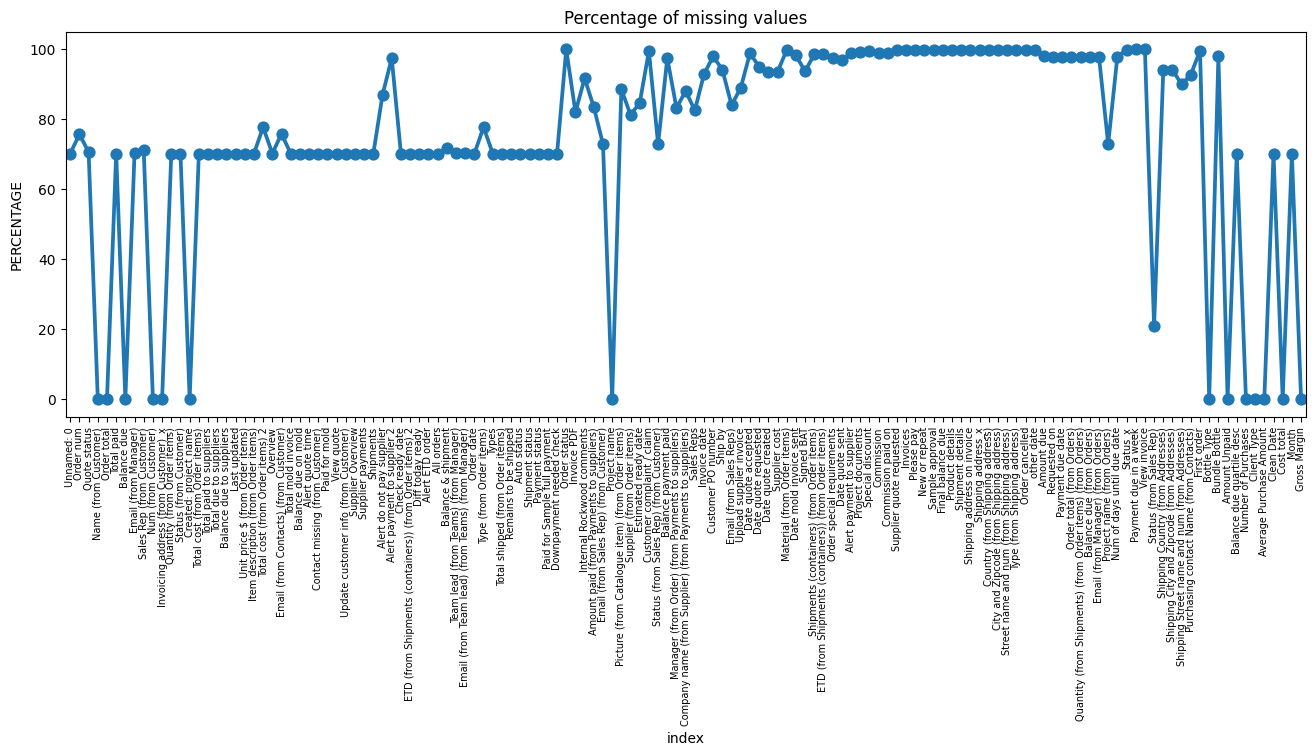

In [24]:
#calculating missing values
missing= pd.DataFrame((df.isnull().sum())*100/df.shape[0]).reset_index()
plt.figure(figsize = (16,5))
ax = sns.pointplot(x = 'index', y = 0, data = missing)
plt.xticks(rotation = 90, fontsize = 7)
plt.title("Percentage of missing values")
plt.ylabel("PERCENTAGE")
plt.show()

In [25]:
# Drop columns with 100% missing values
columns_to_keep = ['Date quote accepted', 'Date quote created', 'Date quote requested', 'Date quote sent','Quote status','Name (from Customer)','Order status','Order total','Total paid','Balance due','Sales Rep (from Customer)',
             'Quantity (from Order items)','Num (from Customer)','Clean Date','Cost total','Month',
             'Bottle Type','Number of Purchases','Amount Unpaid','Average Purchase Amount','Project name','Types',
             'Unit price $ (from Order items)','Item description (from Order items)',
                  'Order date', 'Date quote created', 'Date quote accepted']
columns_to_drop = df.columns[df.isnull().mean() >= 0.8].difference(columns_to_keep)
df['Clean Date'], df['Month'] = pd.to_datetime(df['Clean Date']), df['Clean Date'].dt.month
df.drop(columns=columns_to_drop, inplace=True)
df.sample()


Unnamed: 0  Order num Quote status  Name (from Customer)  Order total  Total paid  Balance due Email (from Manager) Sales Rep (from Customer)  Num (from Customer) Invoicing address (from Customer)_x  Quantity (from Order items) Status (from Customer) Created: project name  Total cost (from Order items)  Total paid to suppliers  Total due to suppliers  Balance due to suppliers Last updated  Unit price $ (from Order items) Item description (from Order items) Total cost (from Order items) 2 Overview Email (from Contacts) (from Customer)  Total mold invoice  Balance due on mold Alert quote time Contact missing (from Customer)  Paid for mold View quote Update customer info (from Customer) Supplier Overview Supplier payments Shipments Check ready date ETD (from Shipments (containers)) (from Order items) 2 Diff today ready Alert ETD order All orders Balance & shipment Team lead (from Teams) (from Manager) Email (from Team lead) (from Teams) (from Manager) Order date Type (from Order items) Types  Total shipped (from Order items)  Remains to be shipped Auto status Shipment status Payment status  Paid for Sample full payment  Downpayment needed check Order status Email (from Sales Rep) (from Customer) Project name Status (from Sales Rep) (from Customer) Date quote accepted Date quote requested Date quote created Date quote sent Project name (from Orders) Status (from Sales Rep) Bottle Type  Amount Unpaid Balance due quartile desc  Number of Purchases Client Type  Average Purchase Amount Clean Date  Cost total  Month  Gross Margin
174         NaN        NaN          NaN  Creative Juiices Inc          0.0         NaN          0.0                  NaN                       NaN                 1340                                , ,                           NaN                    NaN                   nan                            NaN                      NaN                     NaN                       NaN          NaN                              NaN                                 NaN                             NaN      NaN                                   NaN                 NaN                  NaN              NaN                             NaN            NaN        NaN                                  NaN               NaN               NaN       NaN              NaN                                                NaN                  NaN             NaN        NaN                NaN                                   NaN                                                NaN        NaT                     NaN   NaN                               NaN                    NaN         NaN             NaN            NaN                           NaN                       NaN         None                                    NaN      Unknown                                     NaN                 NaN                  NaT                NaT             NaT                        NaN              ['Active']         N/A            0.0                       NaN                    1         New                      0.0        NaT         0.0    NaN           0.0

In [26]:
col_churn = ['Quote status','Name (from Customer)','Order num','Order status','Order total','Total paid','Balance due','Sales Rep (from Customer)',
             'Quantity (from Order items)','Num (from Customer)','Clean Date','Cost total','Month',
             'Bottle Type','Number of Purchases','Amount Unpaid','Average Purchase Amount','Project name','Types',
             'Unit price $ (from Order items)','Item description (from Order items)',
             'Order date', 'Date quote created', 'Date quote accepted'
            ]

In [28]:
df['Date quote accepted'] = pd.to_datetime(df['Date quote accepted'], errors='coerce')

In [29]:
df = df[col_churn]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Quote status                         219 non-null    object        
 1   Name (from Customer)                 745 non-null    object        
 2   Order num                            181 non-null    float64       
 3   Order status                         0 non-null      object        
 4   Order total                          745 non-null    float64       
 5   Total paid                           222 non-null    float64       
 6   Balance due                          745 non-null    float64       
 7   Sales Rep (from Customer)            215 non-null    object        
 8   Quantity (from Order items)          222 non-null    float64       
 9   Num (from Customer)                  745 non-null    int64         
 10  Clean Date    

In [ ]:
# # Function to extract country and city
# def extract_country_and_city(address):
#     if pd.isna(address) or address == "[', , ']":
#         return pd.Series([None, None])
#     parts = address.split(', ')
#     if len(parts) >= 3:
#         country = parts[-1].strip(" '[]")
#         city = parts[-2]
#         return pd.Series([country, city])
#     return pd.Series([None, None])

# # Apply the function to create 'Country' and 'City' columns
# df[['Country', 'City']] = df['Invoicing address (from Customer)_x'].apply(extract_country_and_city)


In [ ]:
df.Country.unique(),df.City.unique(),

#### Is data clean?

In [30]:
df.columns

Index(['Quote status', 'Name (from Customer)', 'Order num', 'Order status', 'Order total', 'Total paid', 'Balance due', 'Sales Rep (from Customer)', 'Quantity (from Order items)', 'Num (from Customer)', 'Clean Date', 'Cost total', 'Month', 'Bottle Type', 'Number of Purchases', 'Amount Unpaid', 'Average Purchase Amount', 'Project name', 'Types', 'Unit price $ (from Order items)', 'Item description (from Order items)', 'Order date', 'Date quote created', 'Date quote accepted'], dtype='object')

In [127]:
def calculate_churn(df):
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()

    # Convert 'Clean Date' column to datetime
    df['Clean Date'] = pd.to_datetime(df['Clean Date'])

    # Sort DataFrame by customer and date
    df.sort_values(by=['Num (from Customer)', 'Clean Date'], inplace=True)

    # Drop duplicates based on 'Order num' and keep the latest row
    df = df.drop_duplicates(subset=['Num (from Customer)', 'Order num'], keep='last')

    # Calculate days since last transaction and days between last and previous-to-last transaction
    df['Days Since Last Transaction'] = df.groupby('Num (from Customer)')['Clean Date'].diff().dt.days
    df['Days Between Last Two Transactions'] = df.groupby('Num (from Customer)')['Clean Date'].diff(periods=2).dt.days

    # Create 'Churn' column based on conditions
    df['Churn'] = np.where(
        (df['Days Since Last Transaction'] > 60) | 
        (df['Days Between Last Two Transactions'] > 60) |
        (pd.isna(df['Days Since Last Transaction']) | pd.isna(df['Days Between Last Two Transactions'])),
        1,
        0
    )

    return df

In [128]:
df = calculate_churn(df)

In [133]:
df[df['Churn']==1].groupby('Name (from Customer)').describe().head()

Order num                                                     Order total                                                                  Total paid                                    Balance due                                                                  Quantity (from Order items)                                                                Clean Date                                                                                                                                                                      Cost total                                                                 Number of Purchases                                    Amount Unpaid                                                                  Average Purchase Amount                                                            Unit price $ (from Order items)                                              Date quote accepted                                    Days Since Last Transaction                                   Days Between Last Two Transactions                              Churn                                    Days since last order                                                                  Recency                                                            Frequency                                    Monetary                                                                      R                                        F                                        M                                    RFM Score                                               
                         count   mean  min    25%    50%    75%    max         std       count     mean  min      25%      50%       75%       max          std      count mean  min  25%  50%  75%  max  std       count     mean  min      25%      50%       75%       max          std                       count     mean  min     25%      50%      75%      max           std      count                        mean                  min                            25%                         50%                            75%                  max  std      count     mean  min      25%      50%      75%      max           std               count mean  min  25%  50%  75%  max  std         count     mean       min       25%      50%      75%  max          std                   count     mean      min      25%      50%      75%      max  std                           count  mean  min  25%   50%   75%   max        std               count mean  min  25%  50%  75%  max  std                       count mean  min  25%  50%  75%  max std                              count mean min 25% 50% 75% max std count mean  min  25%  50%  75%  max  std                 count     mean      min       25%      50%       75%      max      std   count     mean      min      25%      50%      75%      max  std     count mean  min  25%  50%  75%  max  std    count      mean       min       25%       50%       75%       max  std count mean  min  25%  50%  75%  max  std count mean  min  25%  50%  75%  max  std count mean  min  25%  50%  75%  max  std     count   mean    min    25%    50%    75%    max  std
Name (from Customer)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [38]:
# Check the amounnt of missing value
check_missing = df.isnull().sum() * 100 / df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

Order status                           100.000000
Date quote accepted                     98.885794
Date quote created                      95.682451
Days Between Last Two Transactions      86.350975
Days Since Last Transaction             82.451253
Order num                               75.348189
Sales Rep (from Customer)               73.537604
Quote status                            73.259053
Total paid                              72.841226
Quantity (from Order items)             72.841226
Clean Date                              72.841226
Month                                   72.841226
Types                                   72.841226
Unit price $ (from Order items)         72.841226
Item description (from Order items)     72.841226
Order date                              72.841226
dtype: float64

In [39]:
df.isnull().sum()

Quote status                           526
Name (from Customer)                     0
Order num                              541
Order status                           718
Order total                              0
Total paid                             523
Balance due                              0
Sales Rep (from Customer)              528
Quantity (from Order items)            523
Num (from Customer)                      0
Clean Date                             523
Cost total                               0
Month                                  523
Bottle Type                              0
Number of Purchases                      0
Amount Unpaid                            0
Average Purchase Amount                  0
Project name                             0
Types                                  523
Unit price $ (from Order items)        523
Item description (from Order items)    523
Order date                             523
Date quote created                     687
Date quote 

In [40]:
duplicate = df.duplicated()
print(duplicate.sum())

0


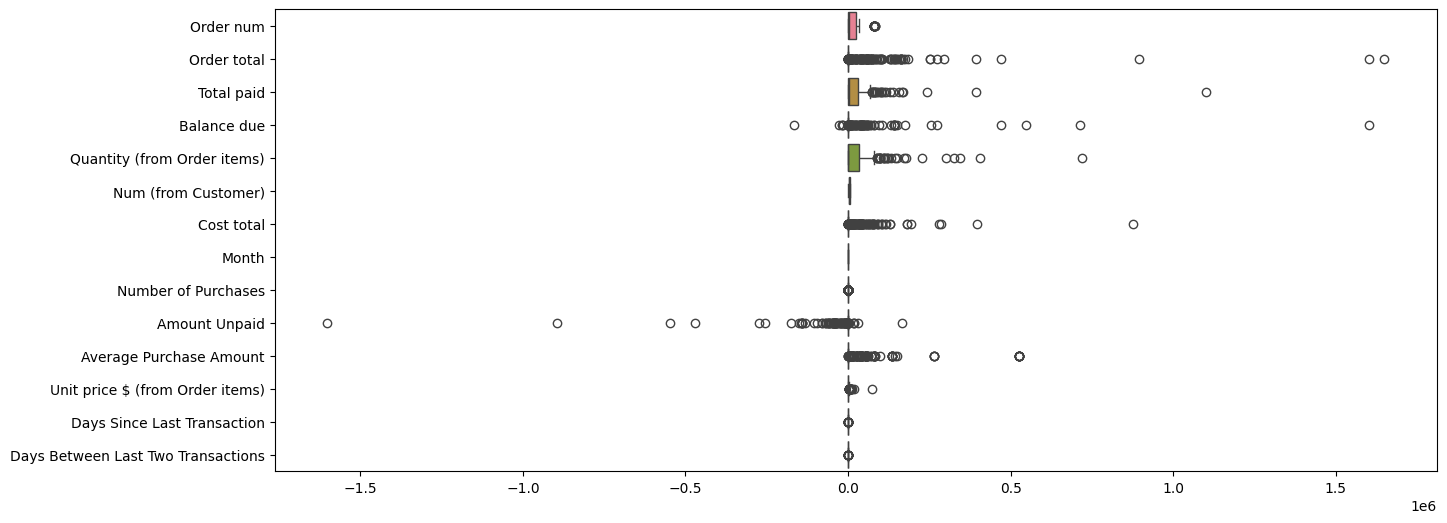

In [41]:
#Check Outliers
num_cols = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(15,6))
#num_cols.boxplot()
sns.boxplot(data=num_cols, orient = 'h')
plt.show()

In [42]:
# Grab cols
cols = df.columns

cat_cols = [col for col in cols if df[col].dtype == "O" and df[col].nunique() < 10]
num_cols = [col for col in cols if df[col].dtype != "O"]
num_but_cat = [col for col in num_cols if col in num_cols and df[col].nunique() < 10]

cat_cols = cat_cols + num_but_cat
num_cols = [col for col in num_cols if col not in num_but_cat]

binary_cols = [col for col in cols if df[col].nunique() == 2]
ohe_cols = [col for col in cat_cols if df[col].nunique() > 2]

#cat_cols.remove(target)

print("Categorical_cols: ", cat_cols, "\n")
print("Numerical cols: ", num_cols, "\n")
print("Binary cols: ", binary_cols, "\n")
print("Ohe_cols: ", ohe_cols, "\n")

Categorical_cols:  ['Quote status', 'Order status', 'Sales Rep (from Customer)', 'Bottle Type', 'Month', 'Date quote accepted', 'Churn'] 

Numerical cols:  ['Order num', 'Order total', 'Total paid', 'Balance due', 'Quantity (from Order items)', 'Num (from Customer)', 'Clean Date', 'Cost total', 'Number of Purchases', 'Amount Unpaid', 'Average Purchase Amount', 'Unit price $ (from Order items)', 'Order date', 'Date quote created', 'Days Since Last Transaction', 'Days Between Last Two Transactions'] 

Binary cols:  ['Churn'] 

Ohe_cols:  ['Quote status', 'Sales Rep (from Customer)', 'Bottle Type', 'Month', 'Date quote accepted'] 



In [43]:
df[cat_cols].nunique()

Quote status                 4
Order status                 0
Sales Rep (from Customer)    8
Bottle Type                  8
Month                        4
Date quote accepted          7
Churn                        2
dtype: int64

In [44]:
# Replace NaN values in the specified numerical columns with 0
df[num_cols] = df[num_cols].fillna(0)

In [45]:
df.isnull().sum().any()

True

In [46]:
df.duplicated().sum().any()

False

In [47]:
df['Quote status'].value_counts()

Quote status
Feedback pending    181
Accepted              7
Sampling              3
Negotiation           1
Name: count, dtype: int64

In [48]:
df.sample(5)

Quote status                               Name (from Customer)  Order num Order status  Order total  Total paid  Balance due Sales Rep (from Customer)  Quantity (from Order items)  Num (from Customer)           Clean Date  Cost total  Month Bottle Type  Number of Purchases  Amount Unpaid  Average Purchase Amount                    Project name        Types  Unit price $ (from Order items) Item description (from Order items)           Order date   Date quote created Date quote accepted  Days Since Last Transaction  Days Between Last Two Transactions  Churn
608          NaN                   M S Rayyan Mineral Water Company        0.0         None          0.0         0.0          0.0                       NaN                          0.0                 5830                    0         0.0    NaN         N/A                    1            0.0                      0.0                         Unknown          NaN                              0.0                                 NaN                    0                    0                 NaT                          0.0                                 0.0      1
147          NaN                            Michael Christopher Ltd        0.0         None          0.0         0.0          0.0                       NaN                          0.0                 1080                    0         0.0    NaN         N/A                    1            0.0                      0.0                         Unknown          NaN                              0.0                                 NaN                    0                    0                 NaT                          0.0                                 0.0      1
509          NaN   Indiana Peony Spirit Llc  Fabiola Lopez Martinez        0.0         None          0.0         0.0          0.0                       NaN                          0.0                 4700                    0         0.0    NaN         N/A                    1            0.0                      0.0                         Unknown          NaN                              0.0                                 NaN                    0                    0                 NaT                          0.0                                 0.0      1
732  Negotiation  The National Agricultural Development Company ...      100.0         None       3400.0         0.0       3400.0     ['recf7VFVFSeyapEr0']                          4.0                 6950  2023-09-25 03:48:14         0.0    9.0     Ceramic                    1        -3400.0                   3400.0  Olive Oil Ceramic Bottle 500ml  ['Ceramic']                            850.0         ['Ceramic - Custom Bottle']  2023-09-25 00:00:00  2023-09-25 00:00:00          2023-08-17                          0.0                                 0.0      1
723          NaN                                       Anik Trading        0.0         None          0.0         0.0          0.0                       NaN                          0.0                 6860                    0         0.0    NaN         N/A                    1            0.0                      0.0                         Unknown          NaN                              0.0                                 NaN                    0                    0                 NaT                          0.0                                 0.0      1

In [50]:
df['Churn'].value_counts(normalize= True)

Churn
1    0.876045
0    0.123955
Name: proportion, dtype: float64

In [51]:
# Select numerical columns (int64 and float64)
num_cols = df.select_dtypes(include=['int64', 'float64'])

for column in num_cols.columns:
    Q1 = num_cols[column].quantile(0.25)
    Q3 = num_cols[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define a condition to identify outliers for the current column
    outlier_condition = (num_cols[column] < Q1 - 1.5 * IQR) | (num_cols[column] > Q3 + 1.5 * IQR)

    # Create a DataFrame with outliers for the current column
    outliers_df = df[outlier_condition]
outliers_df

Quote status                               Name (from Customer)  Order num Order status  Order total  Total paid  Balance due Sales Rep (from Customer)  Quantity (from Order items)  Num (from Customer)           Clean Date  Cost total  Month  Bottle Type  Number of Purchases  Amount Unpaid  Average Purchase Amount                                       Project name                                              Types  Unit price $ (from Order items)                Item description (from Order items)           Order date   Date quote created Date quote accepted  Days Since Last Transaction  Days Between Last Two Transactions  Churn
28   Feedback pending                                Aiko Importers  Inc    32500.0         None     80394.50    80394.50         0.00     ['recf7VFVFSeyapEr0']                      27002.0                   10  2023-07-31 07:15:53    56917.14    7.0      Ceramic                   31           0.00                 55845.97      3 Cats Ceramic Bottle 375ml + Whisky Bottling       ['Ceramic', 'Accessories', None, 'Bottling']                          155.590  ['Ceramic - 3 Cats 375ml', 'Accessories - Spec...  2023-07-31 00:00:00                    0                 NaT                          5.0                                 7.0      0
39   Feedback pending                                Aiko Importers  Inc    34300.0         None    103770.00    51885.00     51885.00     ['recf7VFVFSeyapEr0']                      29046.0                   10  2023-07-31 07:16:12    65099.74    7.0      Ceramic                   31      -51885.00                 55845.97  Longhorn Ceramic Bottle 750ml+Bourbon and Colo...       ['Ceramic', 'Accessories', None, 'Bottling']                           33.590  ['Ceramic - Longhorn 750ml', 'Ceramic - Colore...  2023-07-31 00:00:00  2023-09-28 00:00:00                 NaT                          0.0                                 5.0      0
33   Feedback pending                                Aiko Importers  Inc    33600.0         None    105370.00   105330.00        40.00     ['recf7VFVFSeyapEr0']                      42150.0                   10  2023-08-24 18:22:44    73797.61    8.0  Accessories                   31         -40.00                 55845.97                         Takeda Yamoto - Gift boxes                     ['Accessories', 'Glass', None]                           20.720  ['Accessories - Yamato 750ml Armor', 'Glass - ...  2023-08-24 00:00:00                    0                 NaT                         24.0                                24.0      0
36           Sampling                                Aiko Importers  Inc    33900.0         None     81240.00    40585.00     40655.00     ['recf7VFVFSeyapEr0']                      33000.0                   10  2023-08-30 08:25:03    64147.69    8.0  Accessories                   31      -40655.00                 55845.97                             Deringer 200ml Bourbon                           ['Accessories', 'Glass']                           27.080  ['Accessories - Alligator 750ml Zamak  Cap', '...  2023-08-30 00:00:00                    0                 NaT                          5.0                                30.0      0
26   Feedback pending                                Aiko Importers  Inc    31500.0         None    132030.00        0.00    132030.00     ['recf7VFVFSeyapEr0']                      19500.0                   10  2023-09-22 08:20:31    72107.14    9.0      Ceramic                   31     -132030.00                 55845.97                         Eagle Ceramic Bottle 750ml       ['Ceramic', 'Accessories', None, 'Bottling']                           24.630  ['Ceramic - Eagle 750ml', 'Accessories - Gift ...  2023-09-22 00:00:00                    0                 NaT                         22.0                                28.0      0
47   Feedback pending                                Aiko Importers  Inc        0.0         None         0.00        0.00         0.00     

In [52]:
#Check the number of unique value from all of the object datatype
df.select_dtypes(include='object').nunique()

Quote status                             4
Name (from Customer)                   587
Order status                             0
Sales Rep (from Customer)                8
Clean Date                             195
Bottle Type                              8
Project name                           166
Types                                   35
Item description (from Order items)    127
Order date                              33
Date quote created                      13
dtype: int64

In [53]:
df['Clean Date'] = pd.to_datetime(df['Clean Date'])
df['Month'] = df['Clean Date'].dt.month

C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\2726700571.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


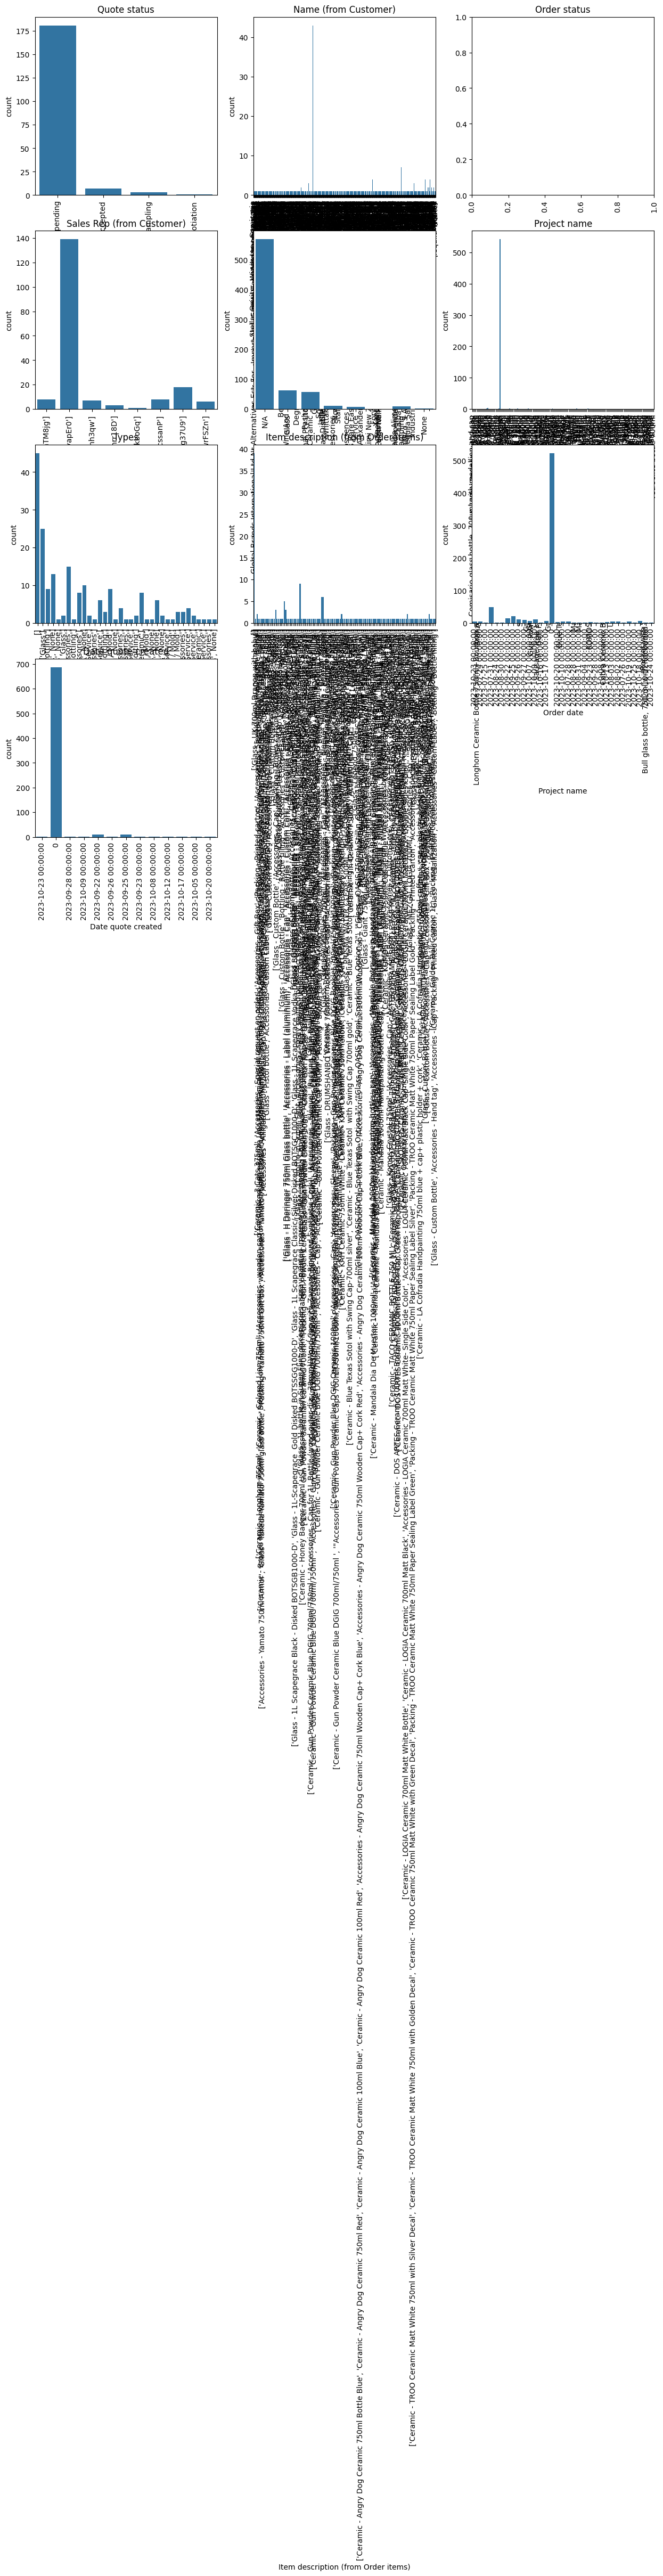

In [54]:
# Get the names of all columns with data type 'object' (categorical columns) excluding 'Country'
cat_vars = df.select_dtypes(include='object').columns.tolist()

# Create a figure with subplots
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Create a countplot for the top 6 values of each categorical variable using Seaborn
for i, var in enumerate(cat_vars):
    top_values = df[var].value_counts().index
    filtered_df = df[df[var].isin(top_values)]
    sns.countplot(x=var, data=filtered_df, ax=axs[i])
    axs[i].set_title(var)
    axs[i].tick_params(axis='x', rotation=90)

# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust spacing between subplots
fig.tight_layout()

# Show plot
plt.show()

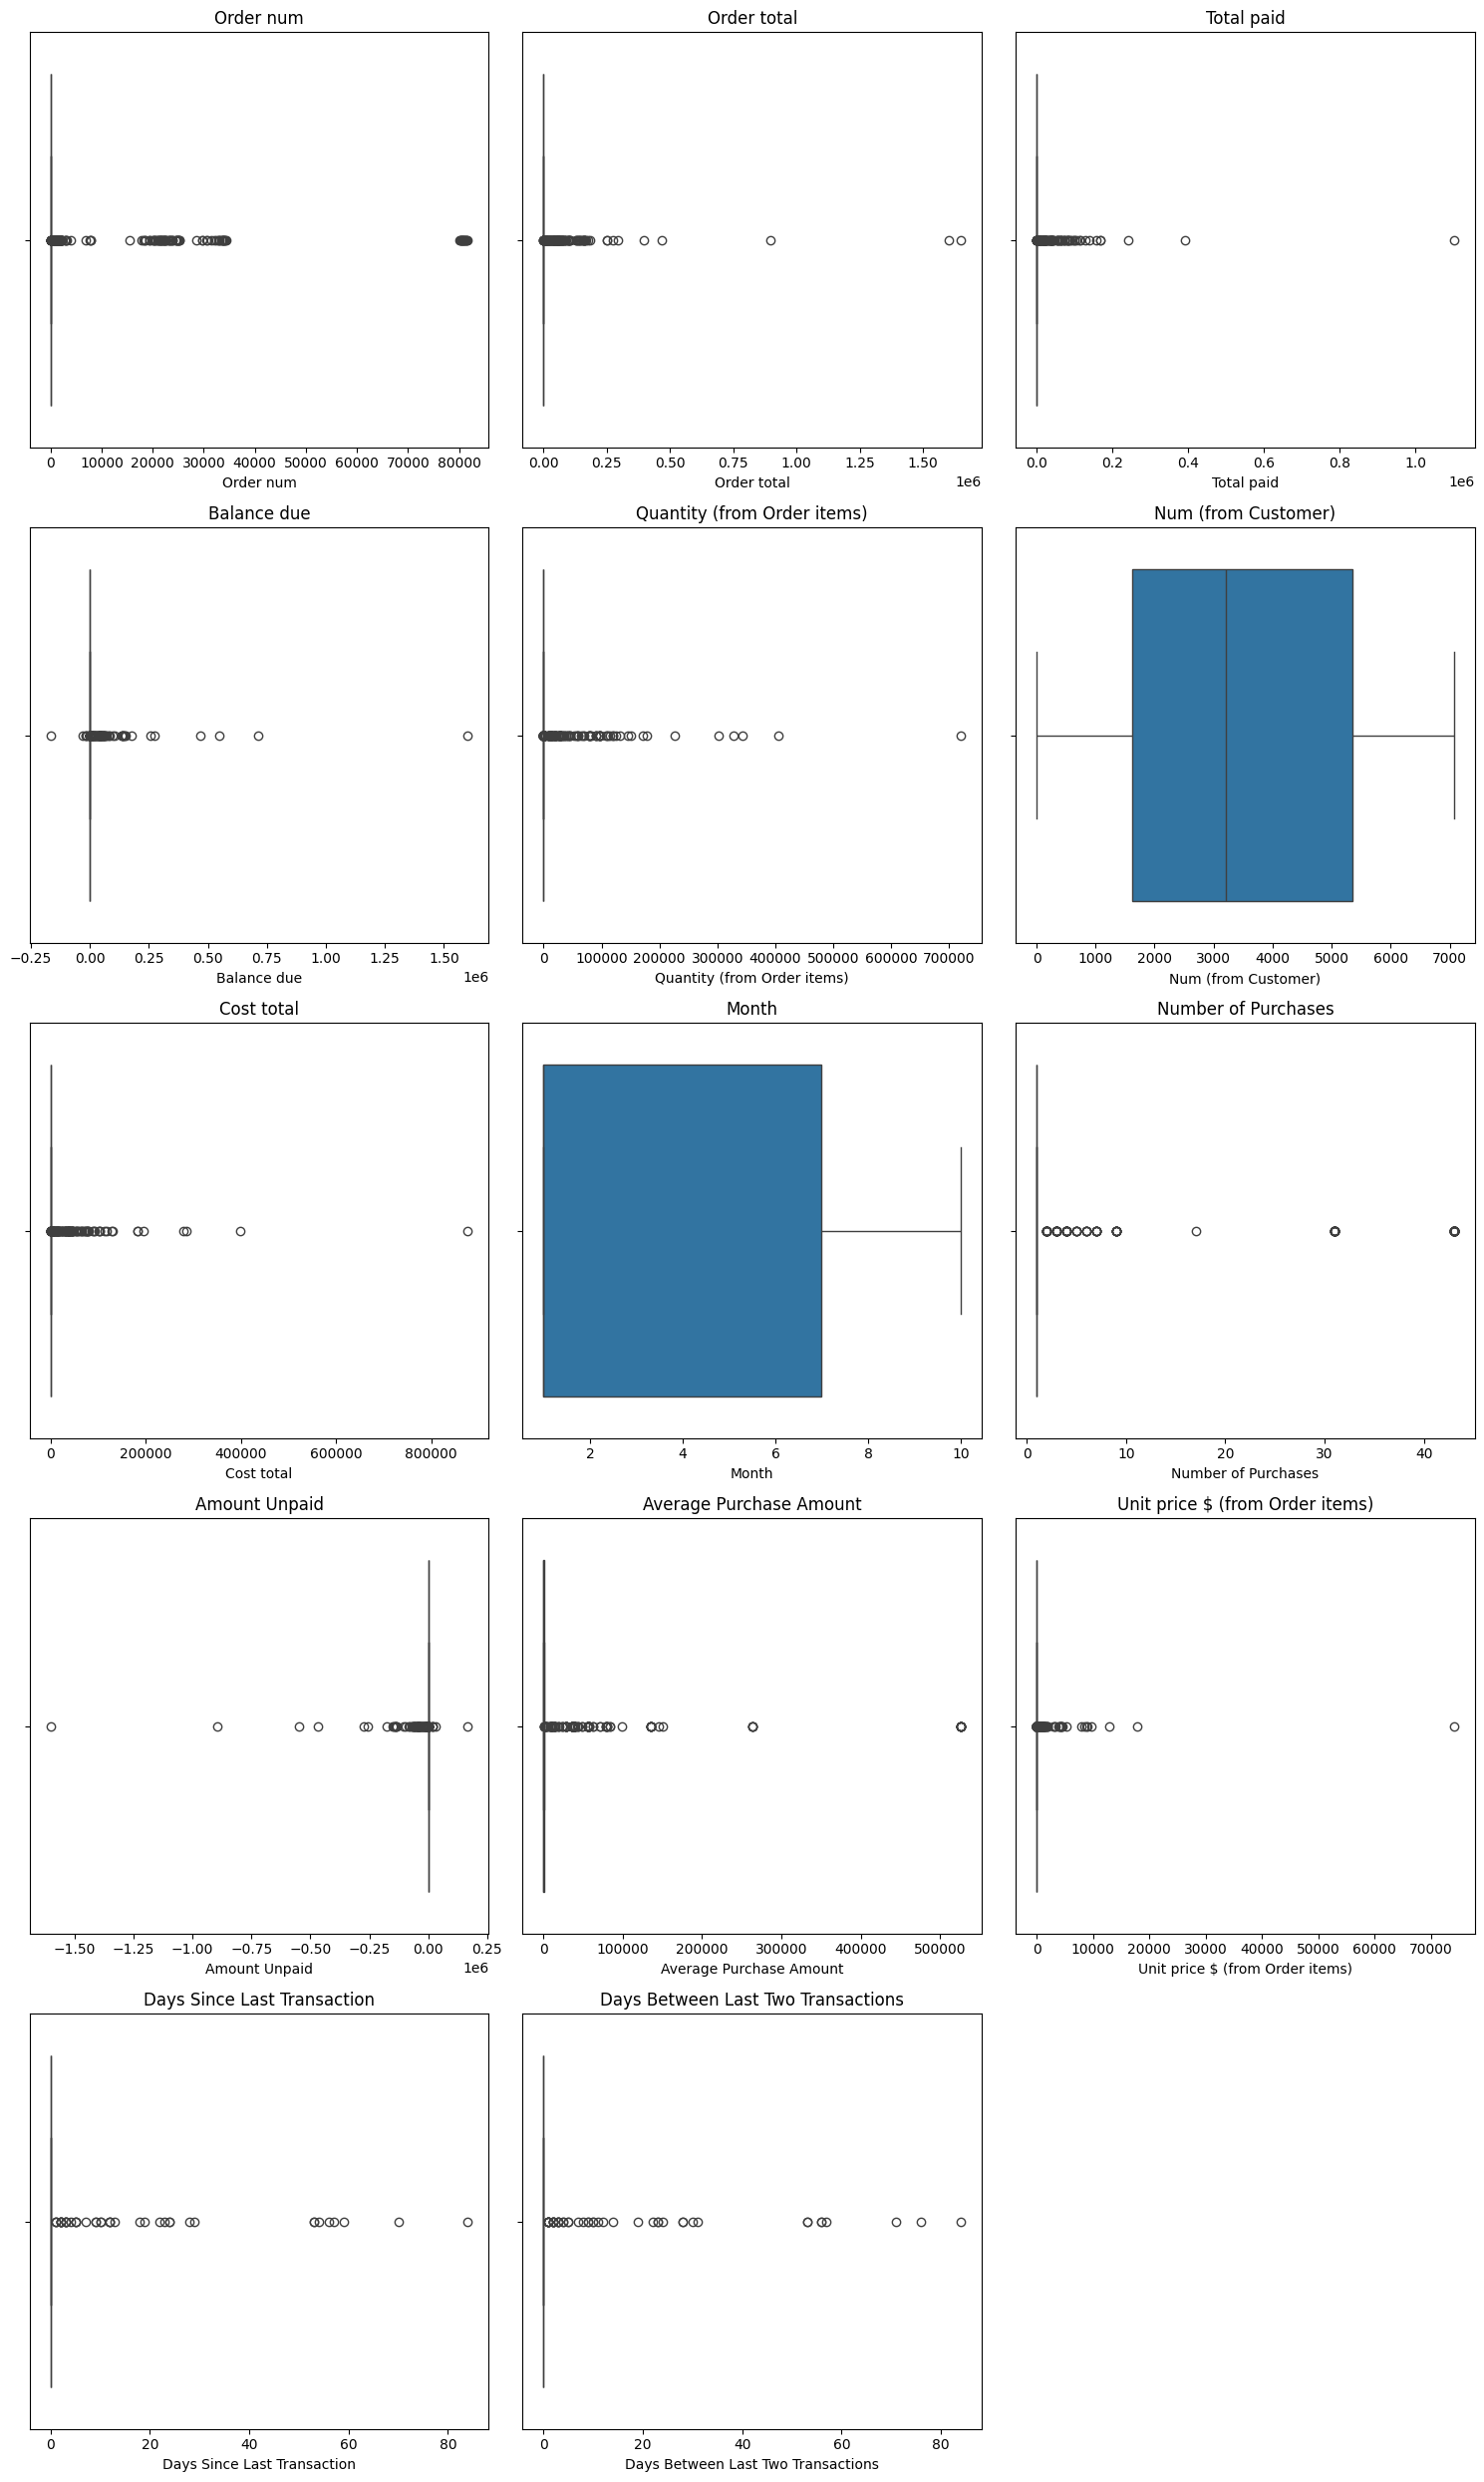

In [55]:
# Get the names of all columns with data type 'int' or 'float', excluding 'churn_risk_score'
num_vars = df.select_dtypes(include=['int', 'float']).columns.tolist()
num_vars = [col for col in num_vars if col != 'Churn']

# Create a figure with subplots
num_cols = len(num_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Create a box plot for each numerical variable using Seaborn
for i, var in enumerate(num_vars):
    sns.boxplot(x=df[var], ax=axs[i])
    axs[i].set_title(var)

# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust spacing between subplots
fig.tight_layout()

# Show plot
plt.show()

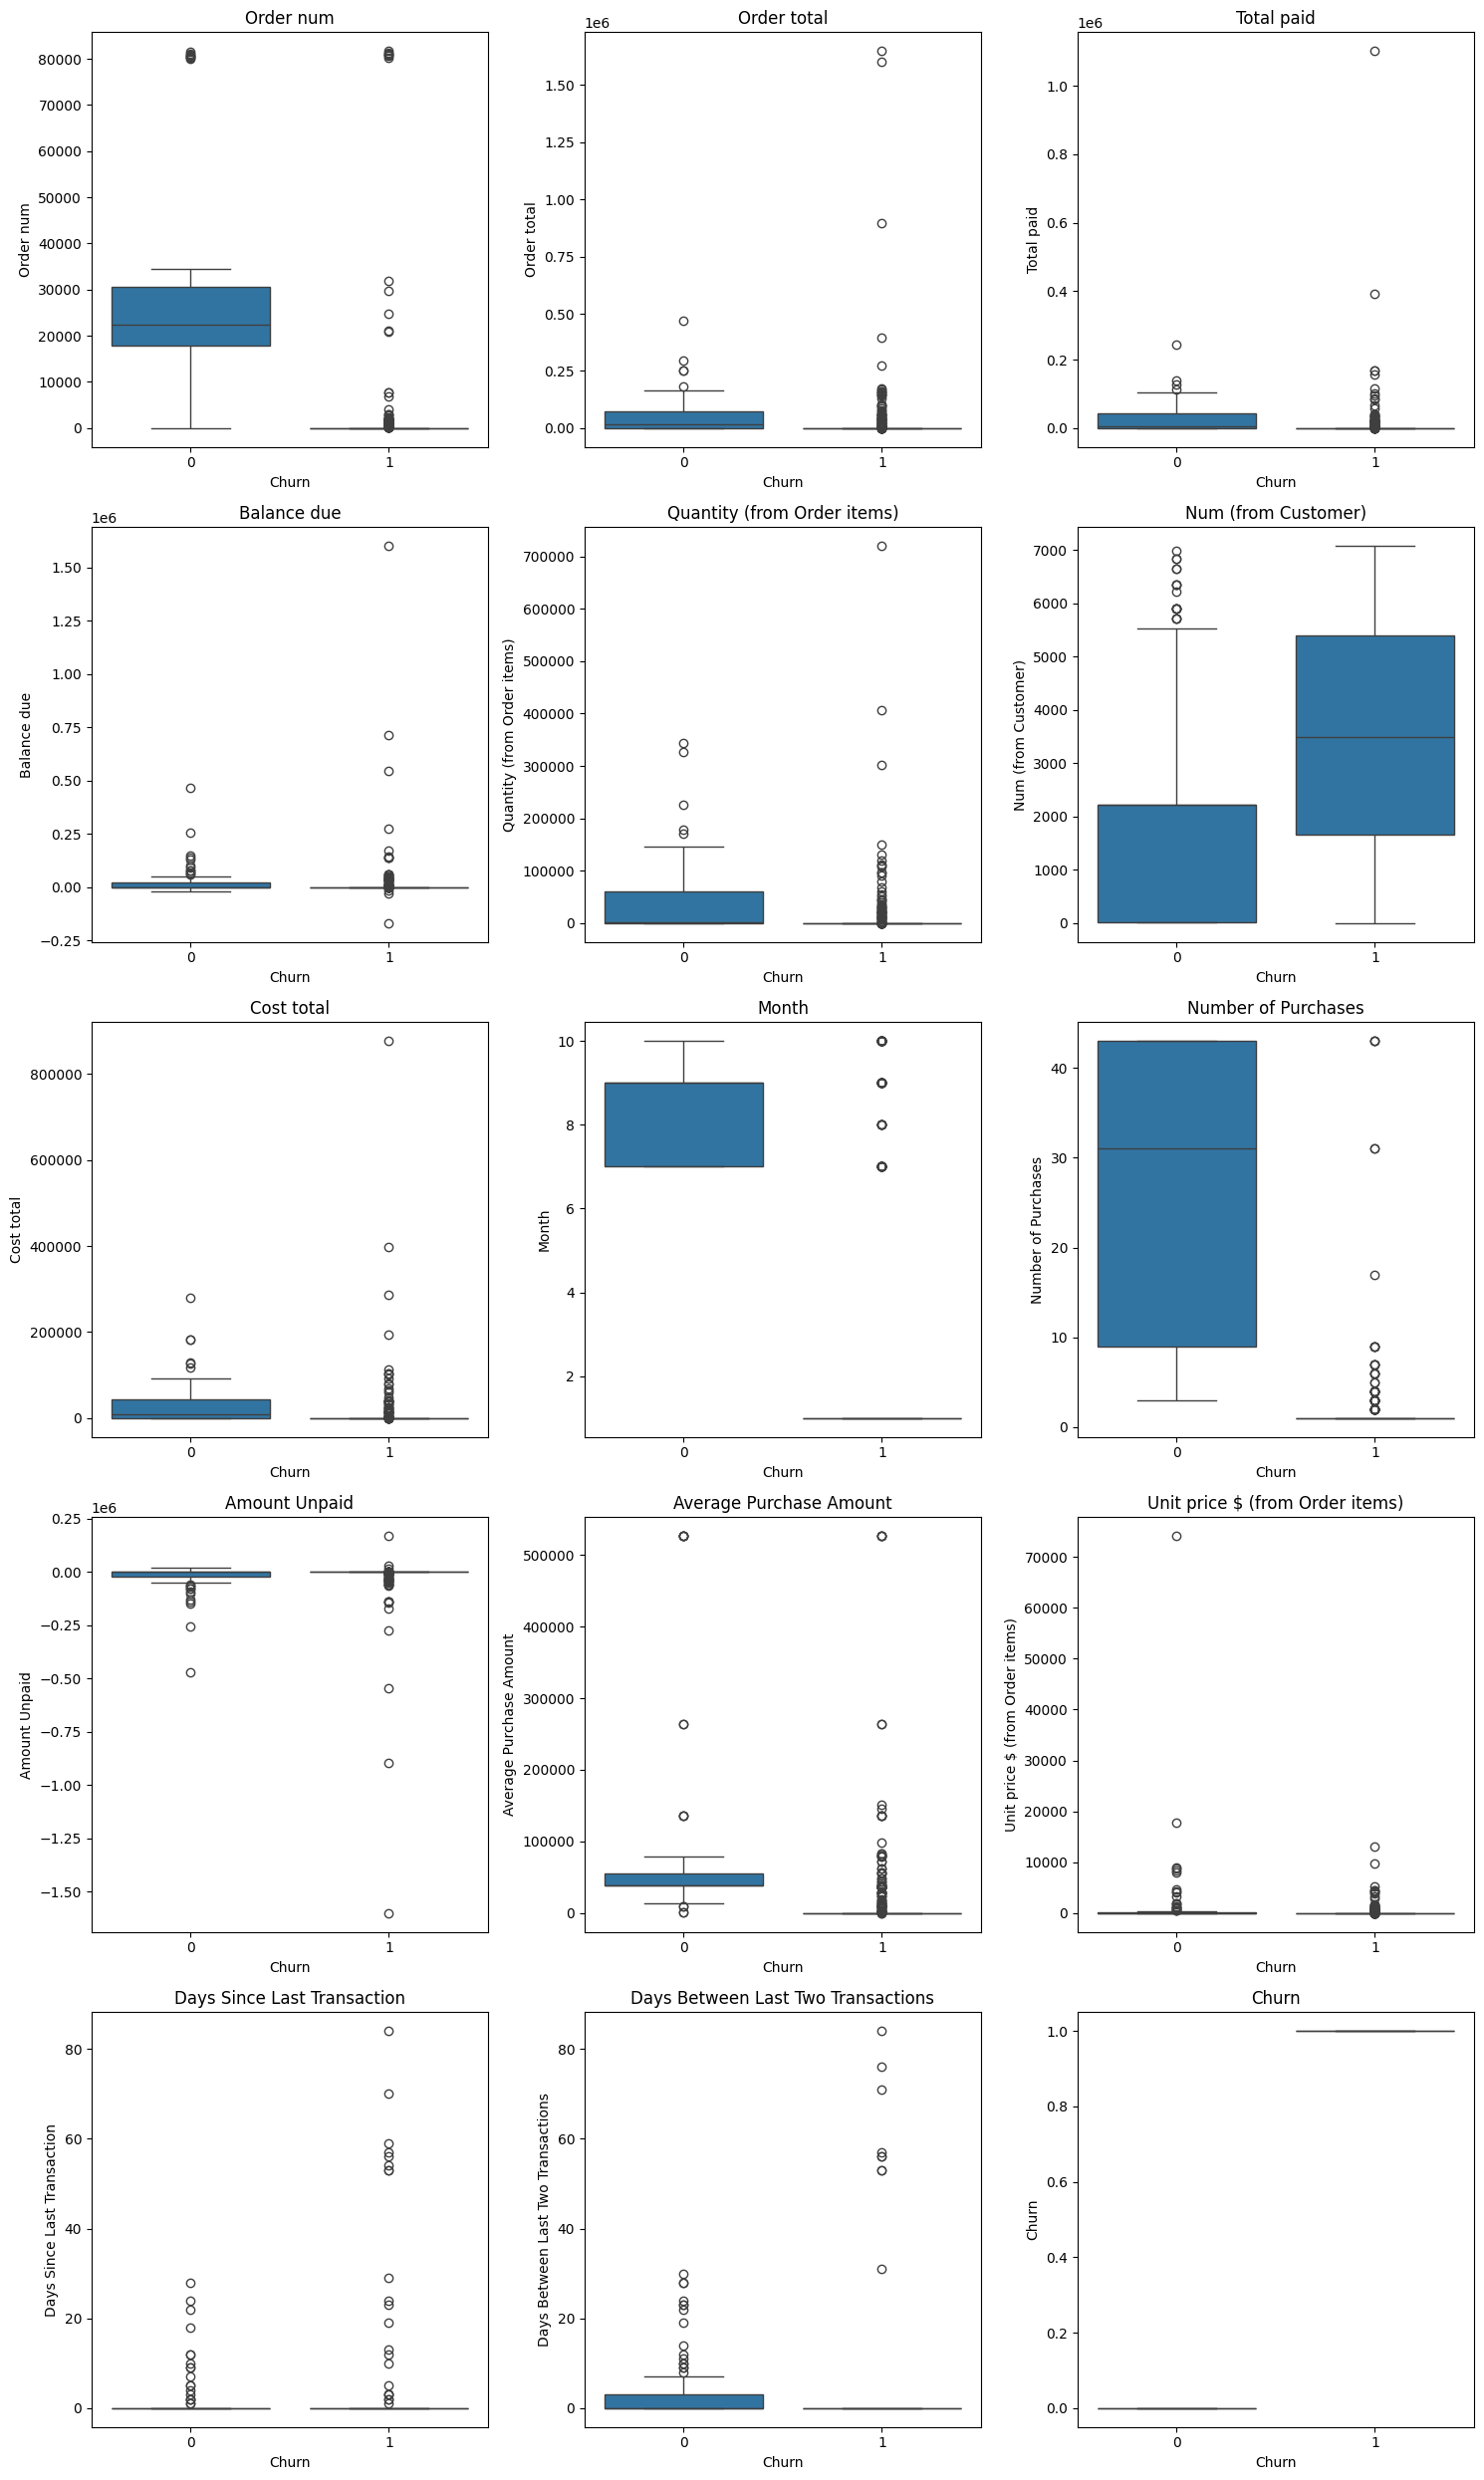

In [56]:
# Get the names of all columns with data type 'int'
int_vars = df.select_dtypes(include=['int', 'float']).columns.tolist()
#int_vars = [col for col in num_vars if col != 'churn_risk_score']

# Create a figure with subplots
num_cols = len(int_vars)
num_rows = (num_cols + 2) // 3  # To make sure there are enough rows for the subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Create a box plot for each integer variable using Seaborn with hue='attrition'
for i, var in enumerate(int_vars):
    sns.boxplot(y=var, x='Churn', data=df, ax=axs[i])
    axs[i].set_title(var)

# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust spacing between subplots
fig.tight_layout()

# Show plot
plt.show()

C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\2209282207.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\2209282207.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\2209282207.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\2209282207.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_

TypeError: '<' not supported between instances of 'int' and 'Timestamp'

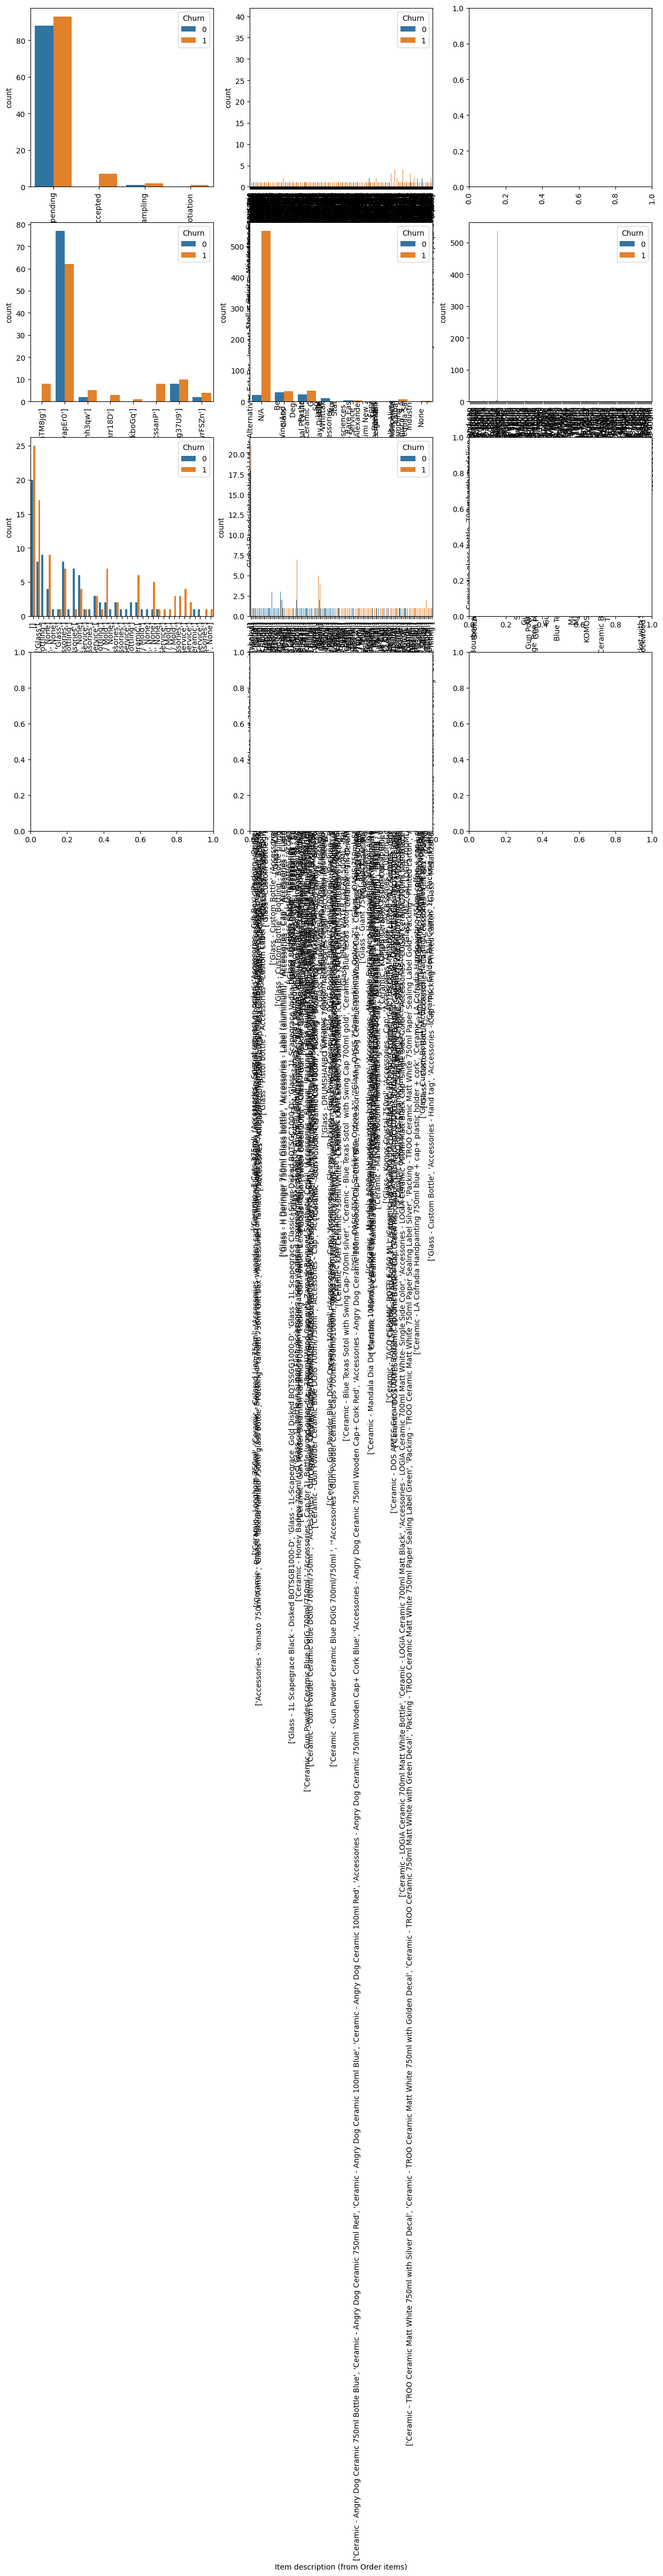

In [57]:
# Get the names of all columns with data type 'object' (categorical variables)
cat_vars = df.select_dtypes(include=['object']).columns.tolist()

# Exclude 'Country' from the list if it exists in cat_vars
if 'Churn' in cat_vars:
    cat_vars.remove('Churn')

# Create a figure with subplots, but only include the required number of subplots
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3  # To make sure there are enough rows for the subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# Create a count plot for each categorical variable
for i, var in enumerate(cat_vars):
    filtered_df = df[df[var].notnull()]  # Exclude rows with NaN values in the variable
    sns.countplot(x=var, hue='Churn', data=filtered_df, ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

# Remove any remaining blank subplots
for i in range(num_cols, len(axs)):
    fig.delaxes(axs[i])

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

AttributeError: 'Series' object has no attribute 'append'

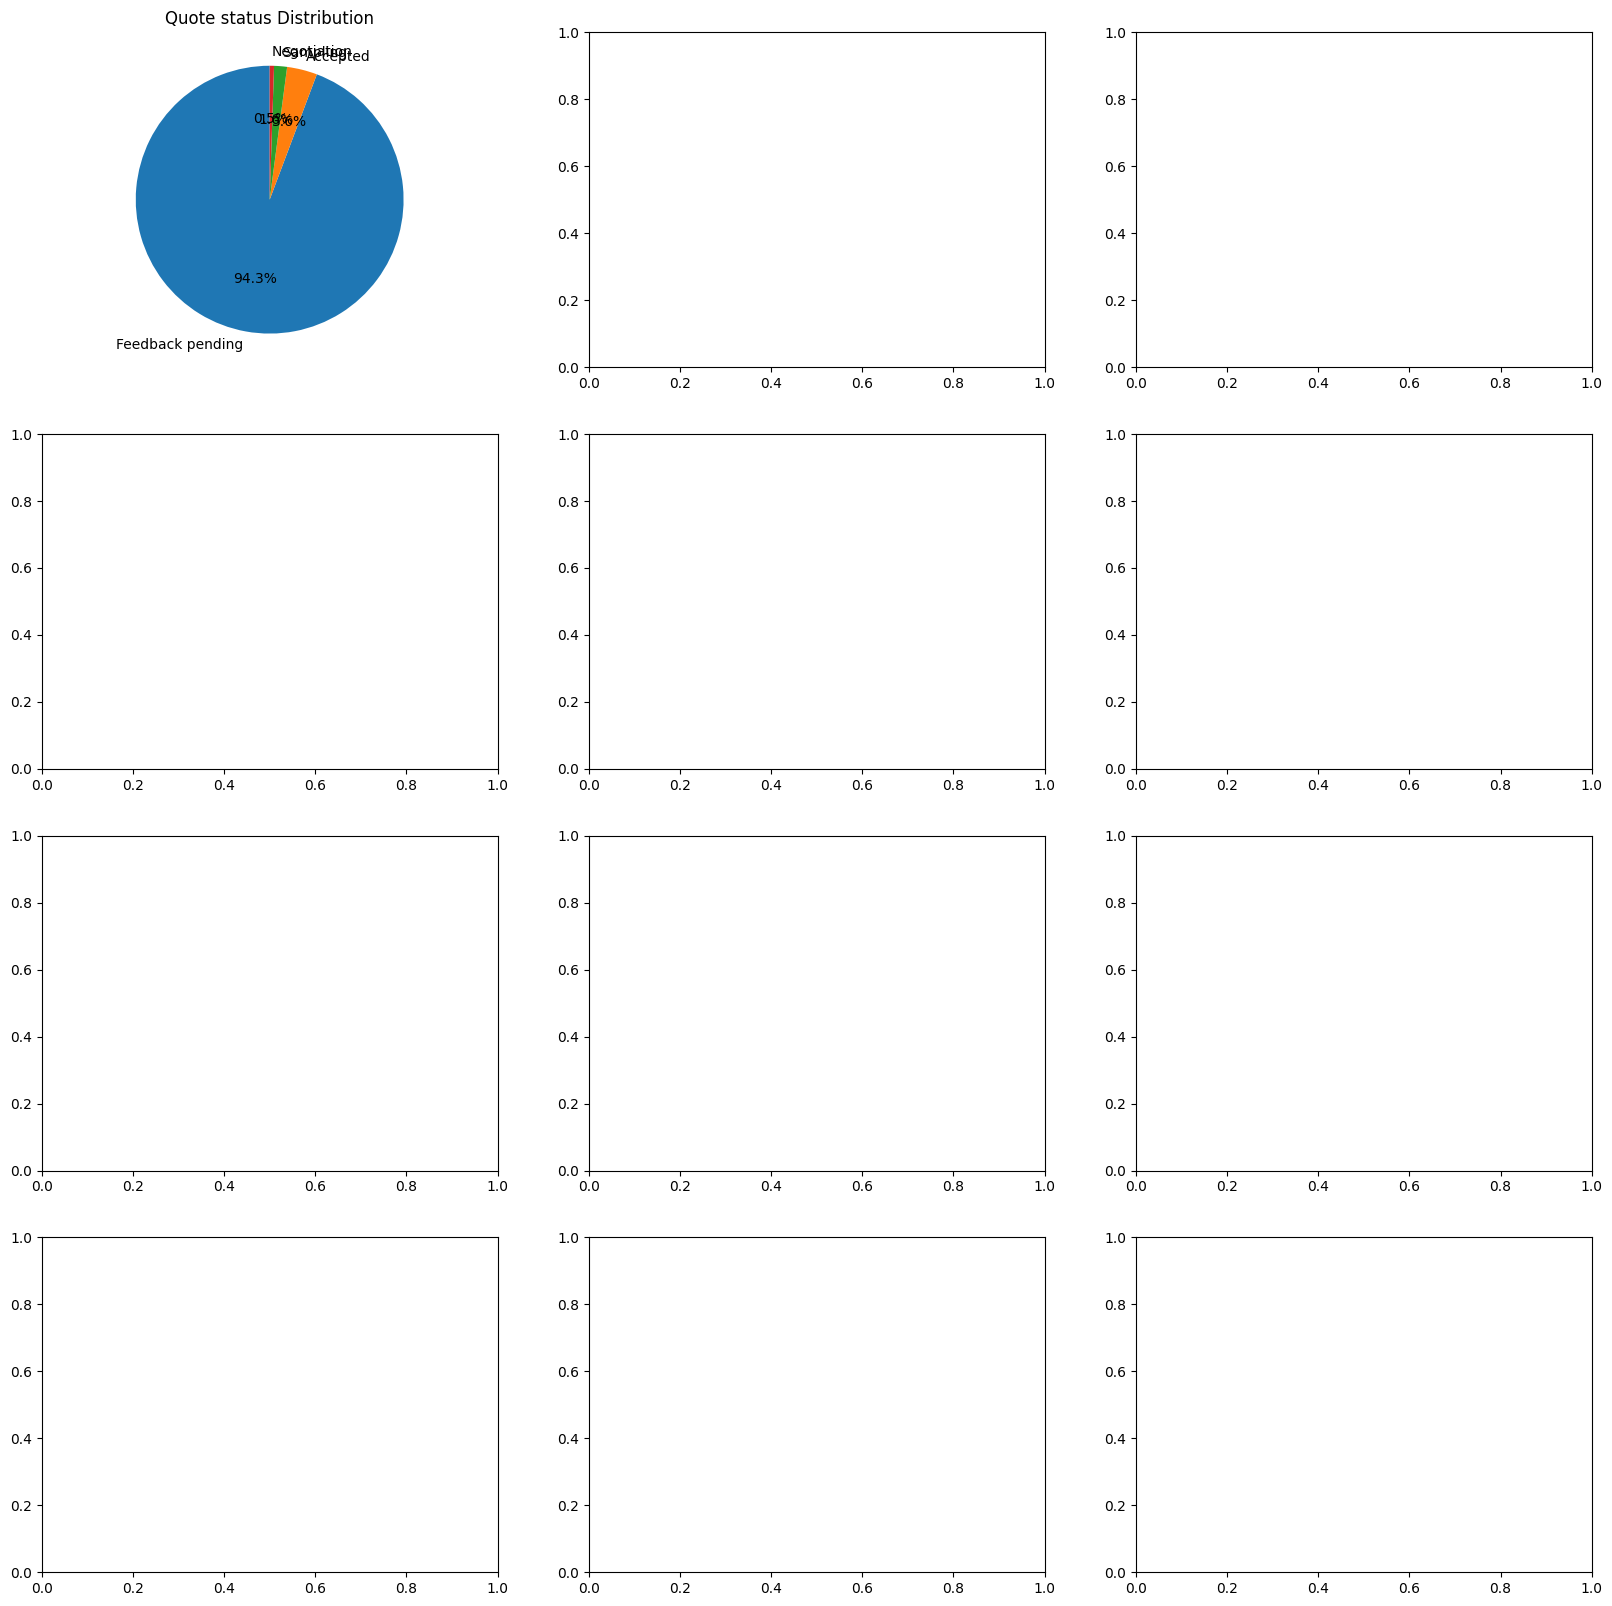

In [58]:
# Specify the maximum number of categories to show individually
max_categories = 5

# Filter categorical columns with 'object' data type
cat_cols = [col for col in df.columns if col != 'y' and df[col].dtype == 'object']

# Create a figure with subplots
num_cols = len(cat_cols)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, 5*num_rows))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Create a pie chart for each categorical column
for i, col in enumerate(cat_cols):
    if i < len(axs):  # Ensure we don't exceed the number of subplots
        # Count the number of occurrences for each category
        cat_counts = df[col].value_counts()

        # Group categories beyond the top max_categories as 'Other'
        if len(cat_counts) > max_categories:
            cat_counts_top = cat_counts[:max_categories]
            cat_counts_other = pd.Series(cat_counts[max_categories:].sum(), index=['Other'])
            cat_counts = cat_counts_top.append(cat_counts_other)

        # Create a pie chart
        axs[i].pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', startangle=90)
        axs[i].set_title(f'{col} Distribution')

# Remove any extra empty subplots if needed
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# Adjust spacing between subplots
fig.tight_layout()

# Show plot
plt.show()

In [59]:
# Filter the DataFrame to include only 'Feedback pending' rows
feedback_pending_df = df[df['Quote status'] == 'Feedback pending']
# Calculate the duration of each 'Feedback pending' status
feedback_pending_df['Duration'] = feedback_pending_df.groupby('Num (from Customer)')['Clean Date'].diff().dt.days
feedback_pending_df.dropna(subset=['Duration'], inplace=True)
# Analyze duration statistics
duration_mean = feedback_pending_df['Duration'].mean()
duration_min = feedback_pending_df['Duration'].min()
duration_max = feedback_pending_df['Duration'].max()
duration_mean,duration_min,duration_max

C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\3758204353.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feedback_pending_df['Duration'] = feedback_pending_df.groupby('Num (from Customer)')['Clean Date'].diff().dt.days
C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\3758204353.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feedback_pending_df.dropna(subset=['Duration'], inplace=True)


(6.084745762711864, 0.0, 84.0)

### DATA PREPROC

In [136]:
cat_cols = [col for col in cols if df[col].dtype == "O" and df[col].nunique() < 10]
num_cols = [col for col in cols if df[col].dtype != "O"]
num_but_cat = [col for col in num_cols if col in num_cols and df[col].nunique() < 10]

cat_cols = cat_cols + num_but_cat
num_cols = [col for col in num_cols if col not in num_but_cat]

binary_cols = [col for col in cols if df[col].nunique() == 2]
ohe_cols = [col for col in cat_cols if df[col].nunique() > 2]


In [138]:
for col in ohe_cols:
    print(df.groupby(col).agg({"Churn": ["mean", "count"]}))
    print("\n#############################\n")

                     Churn      
                      mean count
Quote status                    
Accepted          1.000000     7
Feedback pending  0.480663   181
Negotiation       1.000000     1
Sampling          0.666667     3

#############################

                              Churn      
                               mean count
Sales Rep (from Customer)                
['rec6jdWuvf9Tmh3qw']      0.714286     7
['recExxIMkYrcssanP']      1.000000     8
['recN6S9PWqrPkboGq']      1.000000     1
['recW7Y5lAVi2g37U9']      0.444444    18
['recf7VFVFSeyapEr0']      0.417266   139
['recqmM88sOdhTM8jg']      1.000000     8
['recsPCJB2Nfhrr18D']      1.000000     3
['recwGBTRYPcwrFSZn']      0.666667     6

#############################

            Churn      
             mean count
Month                  
1970-01  1.000000   523
2023-07  0.491803    61
2023-08  0.333333    15
2023-09  0.435484    62
2023-10  0.666667    57

#############################

                Chu

In [134]:
# Outlier functions
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [137]:
for col in num_cols:
    print(col, check_outlier(df, col))

Order num True
Order total True
Total paid True
Balance due True
Quantity (from Order items) True
Clean Date False
Cost total True
Number of Purchases True
Amount Unpaid True
Average Purchase Amount True
Unit price $ (from Order items) True
Days Since Last Transaction True
Days Between Last Two Transactions True


C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\3815803418.py:12: FutureWarning:

'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.

C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\3815803418.py:12: FutureWarning:

'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.

C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\3815803418.py:12: FutureWarning:

'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.

C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\3815803418.py:12: FutureWarning:

'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.

C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\3815803418.py:12: FutureWarning:

'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Times

In [139]:
#NEED TO GET RID OF THE OUTLIERS

### EDA

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 718 entries, 2 to 743
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Quote status                         192 non-null    object        
 1   Name (from Customer)                 718 non-null    object        
 2   Order num                            718 non-null    float64       
 3   Order status                         0 non-null      object        
 4   Order total                          718 non-null    float64       
 5   Total paid                           718 non-null    float64       
 6   Balance due                          718 non-null    float64       
 7   Sales Rep (from Customer)            190 non-null    object        
 8   Quantity (from Order items)          718 non-null    float64       
 9   Num (from Customer)                  718 non-null    int64         
 10  Clean Date         

In [61]:
df.sample()

Quote status  Name (from Customer)  Order num Order status  Order total  Total paid  Balance due Sales Rep (from Customer)  Quantity (from Order items)  Num (from Customer) Clean Date  Cost total  Month Bottle Type  Number of Purchases  Amount Unpaid  Average Purchase Amount Project name Types  Unit price $ (from Order items) Item description (from Order items) Order date Date quote created Date quote accepted  Days Since Last Transaction  Days Between Last Two Transactions  Churn
322          NaN  Castlebajac Creative        0.0         None          0.0         0.0          0.0                       NaN                          0.0                 2630 1970-01-01         0.0      1         N/A                    1            0.0                      0.0      Unknown   NaN                              0.0                                 NaN          0                  0                 NaT                          0.0                                 0.0      1

In [62]:
sorted(df.columns)

['Amount Unpaid',
 'Average Purchase Amount',
 'Balance due',
 'Bottle Type',
 'Churn',
 'Clean Date',
 'Cost total',
 'Date quote accepted',
 'Date quote created',
 'Days Between Last Two Transactions',
 'Days Since Last Transaction',
 'Item description (from Order items)',
 'Month',
 'Name (from Customer)',
 'Num (from Customer)',
 'Number of Purchases',
 'Order date',
 'Order num',
 'Order status',
 'Order total',
 'Project name',
 'Quantity (from Order items)',
 'Quote status',
 'Sales Rep (from Customer)',
 'Total paid',
 'Types',
 'Unit price $ (from Order items)']

In [63]:
projects_overview = df.groupby(['Num (from Customer)',
                                'Name (from Customer)',
                                'Project name','Bottle Type']).agg({'Order num': 'count',
                                                                'Order total':'sum',
                                                                'Quantity (from Order items)':'sum',
                                                                'Unit price $ (from Order items)':'mean'
                                                               })

In [64]:
projects_overview

Order num  Order total  Quantity (from Order items)  Unit price $ (from Order items)
Num (from Customer) Name (from Customer)                               Project name                                       Bottle Type                                                                                      
0                   Stellar Spirits   Wines Inc   Comisario            Comisario glass bottle, 700 ml with medallion a... N/A                  1         0.00                          0.0                           0.0000
10                  Aiko Importers  Inc                                12 zodiac animals  100ml                           Glass                1     46612.80                      12960.0                          53.9500
                                                                       12 zodiac animals 100ml                            Glass                1    161850.00                       9000.0                          53.9500
                                                                       3 Cats Ceramic Bottle 375ml + Whisky Bottling      Ceramic              1     80394.50                      27002.0                         155.5900
                                                                       750ml Baseball Bat Bottle                          Glass                2     75990.52                      14007.0                        2077.5650
                                                                       750ml Ivan Bottle                                  Accessories          2      3830.00                          3.0                        1915.0000
                                                                                                                          Glass                1      8800.00                          2.0                        8800.0000
                                                                       750ml Ivan bottle                                  Glass                1     86810.00                      19000.0                          15.6100
                                                                       AU Dragon 750ml                                    Glass                1     59040.00                       1920.0                          30.7500
                                                                       AU Dragon 750ml Brandy XO 40%                      Glass                1     59136.00                       1920.0                          30.8000
                                                                       Aiko 750ml Alligator Bottle                        Glass                1      7900.00                          3.0                        7900.0000
                                                                       Alligator 750ml                                    Accessories          1      2000.00                          1.0                        2000.0000
                                                                       Bronze Mechanical Bull and Bronze Lion Ceramic ... Ceramic              1     95250.00                      28544.0                          31.3300
                                                                       Certificates Printing                              Accessories          1       945.30                        690.0                           1.3700
                                                                       Deringer 200ml Bourbon                             Accessories          1     81240.00                      33000.0                          27.0800
                                                                       Deringer Pistol 200ml                              Glass                1    162480.00                      60000.0                          27.0800
                                                                       Eagle Ceramic Bottle 750ml                         Ceramic              1    132030.00                  

In [65]:
# clients
client_group = df.groupby(['Num (from Customer)','Name (from Customer)']).agg({'Order total':'sum'}).reset_index()
not_ordering_clients=client_group[client_group['Order total']==0]
percentage_not_going_through = len(not_ordering_clients)/len(client_group)
print(f"Percentage of clients who did not order: {percentage_not_going_through:.2f}%")

Percentage of clients who did not order: 0.91%


In [66]:
test = df['Sales Rep (from Customer)'].iloc[0]
df['Month'] = df['Clean Date'].dt.strftime('%Y-%m')
month = df['Month'].iloc[0]
test, month

("['recqmM88sOdhTM8jg']", '2023-10')

In [67]:
def gantt_df(df, sales_rep, month):
    # Filter the DataFrame based on sales_rep and month
    filtered_df = df[(df['Sales Rep (from Customer)'] == sales_rep) & (df['Month'] == month)]

    # Convert date columns to datetime objects
    date_columns = ['Order date', 'Date quote created', 'Date quote accepted']
    for col in date_columns:
        filtered_df[col] = pd.to_datetime(filtered_df[col])
    
    # Group by 'Order num' and 'Name (from Customer)'
    grouped = filtered_df.groupby(['Order num', 'Name (from Customer)'])
    
    # Create the Gantt chart data
    gantt_data = []
    
    for (order_num, customer), group in grouped:
        order_dates = group['Order date'].values[0]
        for _, row in group.iterrows():
            gantt_data.append([customer, order_num, row['Quote status'], order_dates, row['Date quote created'], row['Date quote accepted']])
            order_dates = row['Date quote accepted']
    
    # Create a DataFrame for the Gantt chart data
    gantt_df = pd.DataFrame(gantt_data, columns=['Customer', 'Order num', 'Quote status', 'Start', 'Create', 'Accepted'])
    return gantt_df


In [68]:
gantt_df = gantt_df(df,test,month)

C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\1781551311.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = pd.to_datetime(filtered_df[col])
C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\1781551311.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = pd.to_datetime(filtered_df[col])
C:\Users\Tis\AppData\Local\Temp\ipykernel_1052\1781551311.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [69]:
gantt_df

Customer  Order num      Quote status      Start     Create Accepted
0                           Humberto Effio        0.0  Feedback pending 2023-10-23 2023-10-23      NaT
1  Stellar Spirits   Wines Inc   Comisario        0.0  Feedback pending 2023-10-23 2023-10-23      NaT
2                          Invigortion Ltd      100.0  Feedback pending 2023-10-09 1970-01-01      NaT
3                              Kita Sangyo      100.0  Feedback pending 2023-10-19 1970-01-01      NaT
4                           Humberto Effio    80900.0  Feedback pending 2023-10-13 1970-01-01      NaT

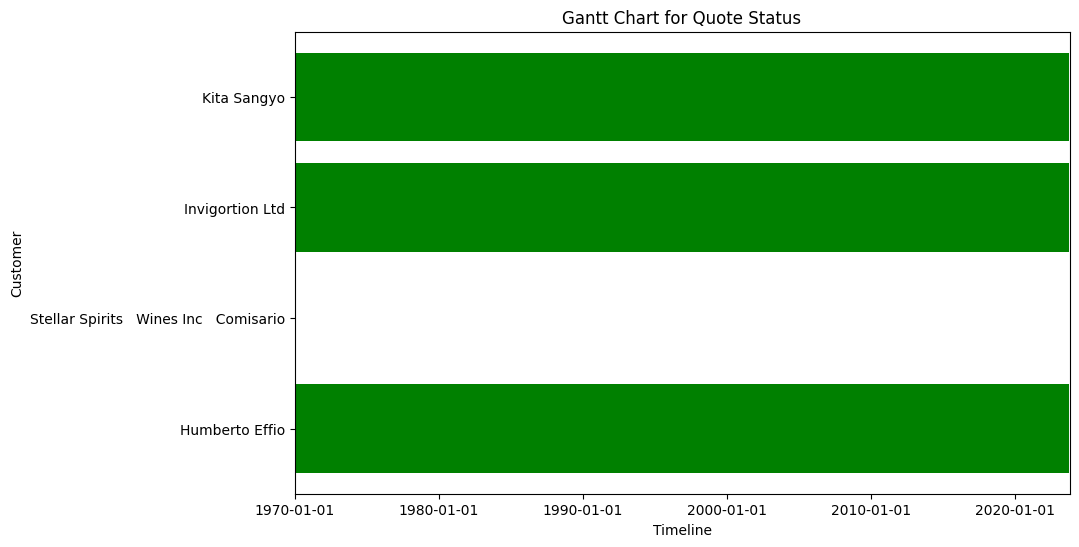

In [70]:
import matplotlib.dates as mdates
# Plot the Gantt chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define custom date formatting
date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis_date()

# Plot Gantt bars
for idx, row in gantt_df.iterrows():
    start = row['Start']
    create = row['Create']
    accepted = row['Accepted']
    customer = row['Customer']
    status = row['Quote status']

    color = 'blue' if status == 'Draft' else 'green'  # Customize colors

    ax.barh(y=customer, left=mdates.date2num(start), width=mdates.date2num(create) - mdates.date2num(start), color=color)
    ax.barh(y=customer, left=mdates.date2num(create), width=mdates.date2num(accepted) - mdates.date2num(create), color=color)

# Set labels and title
ax.set_xlabel('Timeline')
ax.set_ylabel('Customer')
ax.set_title('Gantt Chart for Quote Status')

plt.show()

In [ ]:
# # Sort DataFrame by customer and date
# df.sort_values(by=['Num (from Customer)', 'Clean Date'], inplace=True)
# # Drop duplicates based on 'Order num' and keep the latest row
# df = df.drop_duplicates(subset=['Num (from Customer)', 'Order num'], keep='last')

In [71]:
df['Total paid'].value_counts(normalize=True)

Total paid
0.00          0.831476
800.00        0.004178
850.00        0.004178
1200.00       0.004178
21560.00      0.004178
1450.00       0.002786
20514.00      0.002786
29349.50      0.001393
86970.00      0.001393
74106.74      0.001393
8980.00       0.001393
17736.07      0.001393
1101957.34    0.001393
13000.00      0.001393
19800.00      0.001393
39280.00      0.001393
23040.00      0.001393
36795.26      0.001393
35197.76      0.001393
18508.70      0.001393
15364.00      0.001393
169618.44     0.001393
6913.14       0.001393
25951.82      0.001393
116843.35     0.001393
2400.00       0.001393
4570.00       0.001393
4100.00       0.001393
39830.00      0.001393
1360.00       0.001393
23830.40      0.001393
19955.96      0.001393
1810.00       0.001393
3800.00       0.001393
9958.00       0.001393
99916.00      0.001393
16180.00      0.001393
575.00        0.001393
590.00        0.001393
17280.00      0.001393
3276.00       0.001393
39348.00      0.001393
1500.00       0.001393


In [72]:
df['Quote status'].value_counts(normalize=True)

Quote status
Feedback pending    0.942708
Accepted            0.036458
Sampling            0.015625
Negotiation         0.005208
Name: proportion, dtype: float64

In [73]:
df['Num (from Customer)'].nunique()

592

In [74]:
df['Bottle Type'].value_counts(normalize=True)

Bottle Type
N/A            0.791086
Glass          0.087744
Ceramic        0.079387
Accessories    0.015320
Sampling       0.012535
Service        0.009749
None           0.002786
Perfume        0.001393
Name: proportion, dtype: float64

In [75]:
df['Balance due quartile desc'].value_counts(normalize=True)

KeyError: 'Balance due quartile desc'

In [ ]:
# 46% unpaid yet df['Total paid'] : df['Total paid'].value_counts(normalize=True)
# 94% new quotes is there follow up? df['Quote status'] : df['Quote status'].value_counts(normalize=True)
# 47 different cust df['Num (from Customer)'] but 122 total : df['Num (from Customer)'].nunique()
# Bottle type inside Item description shows 50 ceramic, 48% glass and 2 perfume df['Bottle Type']
# High unpaid balance amount = 7% df['Balance due quartile desc']==1 (64% small amounts)

In [ ]:
# For Lateness of Payments vs. Costs Paid:

# Invoice Due Date: This column can provide the due date for each invoice, allowing you to calculate the payment delay for each transaction.

# Invoice Date: This column can provide the date when the invoice was issued.

# Payment Date: This column can provide the date when the payment was received.

# Payment Status: A column indicating whether the payment was on time, late, or early compared to the due date.

In [ ]:
# For Client Segmentation by Amount and Recurrence by Sales Rep:

# Customer ID: A unique identifier for each customer, allowing you to track and segment customers.

# Sales Rep: The name or ID of the sales representative responsible for the customer.

# Purchase History: A record of all previous transactions for each customer, including the total amount spent, the date of the last purchase, and the number of purchases.

# Client Type: A categorical column indicating whether the customer is a new, returning, or high-value customer.

# Customer Segmentation: A column indicating which segment the customer falls into (e.g., high-value, low-value, frequent buyer, occasional buyer).

# Average Purchase Amount: The average amount spent by each customer.

# Purchase Frequency: The frequency of purchases made by each customer.

# Total Revenue: The total revenue generated by each customer.

# Retention Rate: The percentage of customers who make repeat purchases.

# Churn Rate: The percentage of customers who have not made a purchase in a defined period.

# Customer Lifetime Value (CLV): An estimate of the total revenue a customer is expected to generate over their lifetime as a customer.

# Sales Rep Performance Metrics: Metrics related to the performance of sales representatives, such as the number of customers managed, total sales, and customer satisfaction scores.

In [ ]:
# Payment Lateness Analysis: You mentioned earlier that you want to analyze payment lateness. You can calculate the payment delay for each transaction (the difference between the due date and payment date), identify trends in payment delays, and potentially segment customers based on their payment behaviors.

# Customer Segmentation: You can perform customer segmentation using the RFM (Recency, Frequency, Monetary) analysis. Calculate recency (how recently a customer made a purchase), frequency (how often a customer makes a purchase), and monetary value (how much a customer spends). Segment customers into groups based on these metrics to understand their behavior and tailor marketing strategies accordingly.

# Sales Rep Analysis: Analyze the performance of sales representatives. Calculate metrics like total sales, average purchase amount, and customer satisfaction scores. Identify top-performing sales reps and areas for improvement.

# Client Type Analysis: Examine the distribution of new and returning customers. Understand the differences in behavior and spending between these two groups. Determine strategies to retain and engage both types of customers.

# Predictive Modeling: If you have historical data, consider building predictive models. For example, you can predict customer churn, forecast future sales, or estimate customer lifetime value (CLV) based on historical purchase data.

# Hypothesis Testing: If you have specific questions or hypotheses, conduct hypothesis tests to validate your assumptions or draw statistically significant conclusions.

## 3- Customer behaviour

### 3.1- customer segmentation RFM - behaviour transaction classification

In [ ]:
# #recency
# # Calculate the recency for each customer
# current_date = pd.to_datetime('2023-09-13')  # Replace with your current date
# df['Clean Date'] = pd.to_datetime(df['Clean Date'])
# recency = current_date - df.groupby('Num (from Customer)')['Clean Date'].transform('max')

# # Convert recency to days (you can adjust to other units as needed)
# df['Recency'] = recency.dt.days

# # Print the DataFrame with the 'Recency' column
# df[['Num (from Customer)', 'Recency']].drop_duplicates()

In [ ]:
# #frequency
# # Calculate the frequency for each customer
# frequency = df.groupby('Num (from Customer)')['Order #'].transform('count')

# # Add the 'Frequency' column to the DataFrame
# df['Frequency'] = frequency

# # Print the DataFrame with the 'Frequency' column
# df[['Num (from Customer)', 'Frequency']].drop_duplicates()

In [ ]:
# #monetary value
# # Calculate the monetary value for each customer
# monetary_value = df.groupby('Num (from Customer)')['Invoice total'].transform('sum')

# # Add the 'Monetary Value' column to the DataFrame
# df['Monetary Value'] = monetary_value

# # Print the DataFrame with the 'Monetary Value' column
# df[['Num (from Customer)', 'Monetary Value']].drop_duplicates()

In [ ]:
#RFM

In [83]:
NOW = df['Clean Date'].max() + timedelta(days=1)
period = 365
NOW, period

(Timestamp('2023-10-26 02:25:54'), 365)

In [84]:
print('Orders from {} to {}'.format(df['Clean Date'].min(),
                                    df['Clean Date'].max()))

Orders from 1970-01-01 00:00:00 to 2023-10-25 02:25:54


In [85]:
#Recenecy
df['Days since last order'] = df['Clean Date'].apply(lambda x: (NOW - x).days)

In [86]:
#Recenecy and Frequency
aggr = {
    'Days since last order': lambda x: x.min(),  # the number of days since last order (Recency)
    'Clean Date': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # the total number of orders in the last period (Frequency)
}
rfm = df.groupby('Num (from Customer)').agg(aggr).reset_index()
rfm.rename(columns={'Days since last order': 'Recency', 'Clean Date': 'Frequency'}, inplace=True)


In [87]:
#Monetary
rfm['Monetary'] = rfm['Num (from Customer)'].apply(lambda x: df[(df['Num (from Customer)'] == x) & \
                                                           (df['Clean Date'] >= NOW - timedelta(days=period))]\
                                                           ['Order total'].sum())
rfm.head()

Num (from Customer)  Recency  Frequency    Monetary
0                    0        2          1        0.00
1                   10        8         28  1676325.12
2                   20    19656          0        0.00
3                   30    19656          0        0.00
4                   40    19656          0        0.00

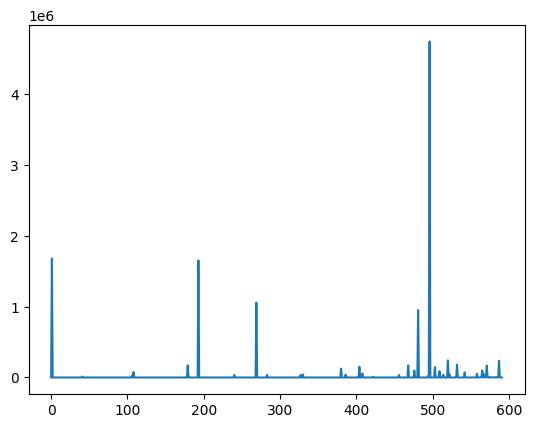

In [88]:
plt.plot(rfm['Monetary'])

In [89]:
#RFM scores : each quintile contains 20% of population
#quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([0.2, 0.4, 0.6, 0.8])

In [90]:
#assign ranks whereby higher monet and higher freq are better but recency smaller better
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

In [91]:
#apply for each cust
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [92]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

Num (from Customer)  Recency  Frequency    Monetary  R  F  M RFM Score
0                    0        2          1        0.00  5  5  1       551
1                   10        8         28  1676325.12  5  5  5       555
2                   20    19656          0        0.00  5  1  1       511
3                   30    19656          0        0.00  5  1  1       511
4                   40    19656          0        0.00  5  1  1       511

In [93]:
# Function to map RFM scores to segments
rfm['RFM Score'] = rfm['RFM Score'].astype(str).astype(int)
def map_segment(rfm_score):
    if rfm_score in [111, 112, 121, 131, 141, 151]:
        return 'Lost'
    elif rfm_score in [332, 322, 231, 241, 251, 233, 232, 223, 222, 132, 123, 122, 212, 211]:
        return 'Hibernating'
    elif rfm_score in [255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124]:
        return 'At Risk'
    elif rfm_score in [331, 321, 312, 221, 213]:
        return 'About To Sleep'
    elif rfm_score in [155, 154, 144, 214, 215, 115, 114, 113]:
        return 'Cannot Lose Them'
    elif rfm_score in [535, 534, 443, 434, 343, 334, 325, 324]:
        return 'Need Attention'
    elif rfm_score in [525, 524, 523, 522, 521, 515, 514, 513, 425, 424, 413, 414, 415, 315, 314, 313]:
        return 'Promising'
    elif rfm_score in [512, 511, 422, 421, 412, 411, 311]:
        return 'New Customer'
    elif rfm_score in [553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323]:
        return 'Potential Loyalist'
    elif rfm_score in [543, 444, 435, 355, 354, 345, 344, 335]:
        return 'Loyal Customer'
    elif rfm_score in [555, 554, 544, 545, 454, 455, 445]:
        return 'Champion'
    else:
        return 'Unknown'

# Apply the mapping function to create the 'Segment' column
rfm['Segment'] = rfm['RFM Score'].apply(map_segment)
rfm.head()

Num (from Customer)  Recency  Frequency    Monetary  R  F  M  RFM Score             Segment
0                    0        2          1        0.00  5  5  1        551  Potential Loyalist
1                   10        8         28  1676325.12  5  5  5        555            Champion
2                   20    19656          0        0.00  5  1  1        511        New Customer
3                   30    19656          0        0.00  5  1  1        511        New Customer
4                   40    19656          0        0.00  5  1  1        511        New Customer

In [94]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_avg = rfm.groupby('Segment').agg({
    'R': lambda x: x.mode().iloc[0],
    'F': lambda x: x.mode().iloc[0],
    'M': lambda x: x.mode().iloc[0],
    'Num (from Customer)': 'count'
}).round(1)
rfm_avg.rename(columns={'Num (from Customer)': 'Count'}, inplace=True)
rfm_avg

R  F  M  Count
Segment                           
Champion            5  5  5     53
New Customer        5  1  1    523
Potential Loyalist  5  5  1     16

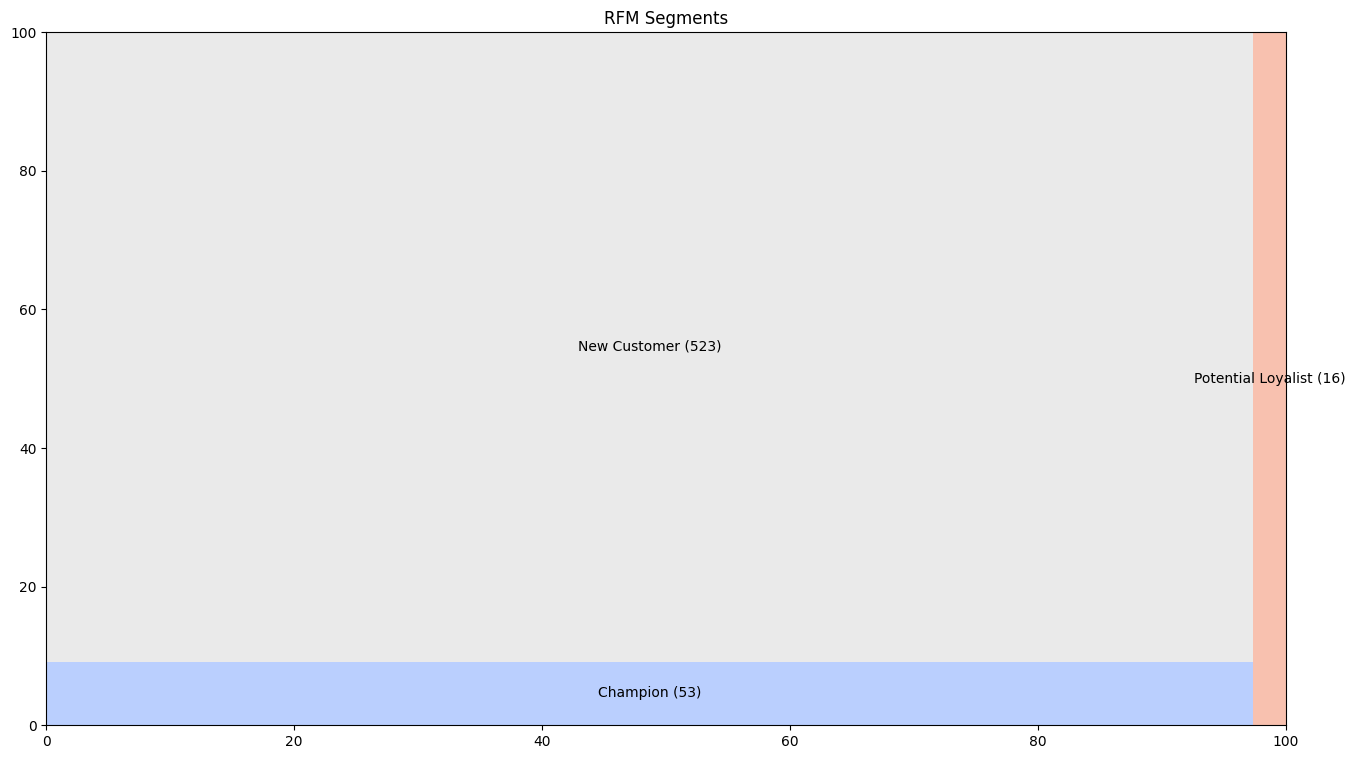

In [95]:
# Create our plot and resize it.
fig, ax = plt.subplots(figsize=(16, 9))

# Use squarify to create the treemap
sizes = rfm_avg['Count']
labels = [f'{label} ({count})' for label, count in zip(rfm_avg.index, sizes)]
colors = sns.color_palette("coolwarm", len(sizes)) 

squarify.plot(sizes=sizes, label=labels, alpha=0.6, color=colors)

# Add title and axis labels
plt.title("RFM Segments")

plt.show()

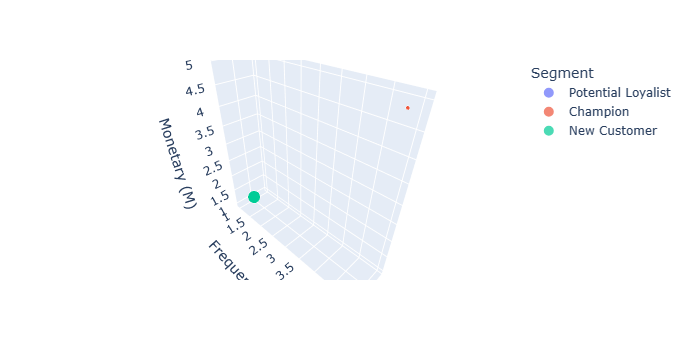

In [96]:
# Calculate the count of unique customers in each segment
segment_counts = rfm.groupby('Segment')['Num (from Customer)'].nunique().reset_index()
segment_counts.rename(columns={'Num (from Customer)': 'Count'}, inplace=True)

# Merge the count information back into the original DataFrame
rfm2 = pd.merge(rfm, segment_counts, on='Segment')

# Create a 3D scatter plot using Plotly Express
fig = px.scatter_3d(
    rfm2,
    x='R',
    y='F',
    z='M',
    color='Segment',
    size='Count',  # Size based on the count of unique customers
    #size_max=10,
    opacity=0.7,
    labels={'Count': 'Customer Count'}  # Label for the size legend
)

# Customize the chart layout
fig.update_layout(scene=dict(xaxis_title='Recency (R)', yaxis_title='Frequency (F)', zaxis_title='Monetary (M)'))

# Show the 3D scatter plot
fig.show()

In [97]:
# Segment	Description https://guillaume-martin.github.io/images/rfm-segments.png
# Champion	Completed a recent purchase. They buy frequently and spend the most. => Reward them. Can be early adopters of new products. They act as brand ambassadors.
# Loyal Customer	Buy on a regular basis. Responsive to promotions. => Upsell. Offer high-value items to them. Ask them for reviews. Build loyalty.
# Potential Loyalist	They recently spent a fair amount of money on the site more than once. => Invite them to join a loyalty program or to get a membership. Recommend other products to them.
# Promising	Bought most recently, but not often enough for us to understand their behaviour. => Support them on their onboarding process. Get their satisfaction. Start to build loyalty.
# New Customer	Completed a recent purchase, but didn’t spend a lot. => Create brand awareness. Offer discounts, gifts and free trials.
# Need Attention	Above average in recency, frequency and monetary value, but no recent purchases. => Launch limited-time offers and recommendations based on previous orders. Reactivate.
# Cannot lose them Completed huge, frequent purchases long ago but haven’t come back since then. => Get them back with new product launches. Don’t let competitors take them. Talk to them.
# About To Sleep	Below average in recency, frequency and monetary value. At risk of losing them if you don’t reactivate. => Share useful information. Recommend popular products to them. Offer new discounts. Reconnect.
# At Risk	Purchased often but a long time ago. Need to bring them back!  => Send personalized emails to reconnect with special offers. Share useful resources with them.
# Hibernating	Their last purchase was long ago. The number of orders was small and the amounts spent low. => Offer relevant products and special discounts. Create brand value again. 
# Lost Lowest scores in recency, frequency and monetary value. => Try to reactivate them with personalized campaigns. If it doesn’t work, ignore them.

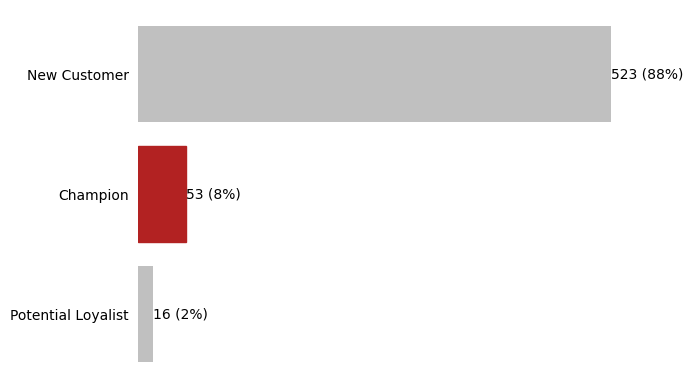

In [98]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Champion', 'Loyal Customer']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [99]:
#map recommendation
# Dictionary to map segments to behavior and potential strategy
segment_mapping = {
    'Champion': {
        'Segment Behavior': 'Completed a recent purchase. They buy frequently and spend the most. Reward them. Can be early adopters of new products. They act as brand ambassadors.',
        'Segment Potential Strategy': 'Reward them. Can be early adopters of new products. They act as brand ambassadors.'
    },
    'Loyal Customer': {
        'Segment Behavior': 'Buy on a regular basis. Responsive to promotions. Upsell. Offer high-value items to them. Ask them for reviews. Build loyalty.',
        'Segment Potential Strategy': 'Upsell. Offer high-value items to them. Ask them for reviews. Build loyalty.'
    },
    'Potential Loyalist': {
        'Segment Behavior': 'They recently spent a fair amount of money on the site more than once. Invite them to join a loyalty program or to get a membership. Recommend other products to them.',
        'Segment Potential Strategy': 'Invite them to join a loyalty program or to get a membership. Recommend other products to them.'
    },
    'Promising': {
        'Segment Behavior': 'Bought most recently, but not often enough for us to understand their behavior. Support them on their onboarding process. Get their satisfaction. Start to build loyalty.',
        'Segment Potential Strategy': 'Support them on their onboarding process. Get their satisfaction. Start to build loyalty.'
    },
    'New Customer': {
        'Segment Behavior': 'Completed a recent purchase, but didn’t spend a lot. Create brand awareness. Offer discounts, gifts, and free trials.',
        'Segment Potential Strategy': 'Create brand awareness. Offer discounts, gifts, and free trials.'
    },
    'Need Attention': {
        'Segment Behavior': 'Above average in recency, frequency, and monetary value, but no recent purchases. Launch limited-time offers and recommendations based on previous orders. Reactivate.',
        'Segment Potential Strategy': 'Launch limited-time offers and recommendations based on previous orders. Reactivate.'
    },
    'Cannot Lose Them': {
        'Segment Behavior': 'Completed huge, frequent purchases long ago but haven’t come back since then. Get them back with new product launches. Don’t let competitors take them. Talk to them.',
        'Segment Potential Strategy': 'Get them back with new product launches. Don’t let competitors take them. Talk to them.'
    },
    'About To Sleep': {
        'Segment Behavior': 'Below average in recency, frequency, and monetary value. At risk of losing them if you don’t reactivate. Share useful information. Recommend popular products to them. Offer new discounts. Reconnect.',
        'Segment Potential Strategy': 'Share useful information. Recommend popular products to them. Offer new discounts. Reconnect.'
    },
    'At Risk': {
        'Segment Behavior': 'Purchased often but a long time ago. Need to bring them back! Send personalized emails to reconnect with special offers. Share useful resources with them.',
        'Segment Potential Strategy': 'Send personalized emails to reconnect with special offers. Share useful resources with them.'
    },
    'Hibernating': {
        'Segment Behavior': 'Their last purchase was long ago. The number of orders was small and the amounts spent low. Offer relevant products and special discounts. Create brand value again.',
        'Segment Potential Strategy': 'Offer relevant products and special discounts. Create brand value again.'
    },
    'Lost': {
        'Segment Behavior': 'Lowest scores in recency, frequency, and monetary value. Try to reactivate them with personalized campaigns. If it doesn’t work, ignore them.',
        'Segment Potential Strategy': 'Try to reactivate them with personalized campaigns. If it doesn’t work, ignore them.'
    }
}



In [100]:
# Map the segments to behavior and potential strategy
rfm['Segment Behavior'] = rfm['Segment'].map(lambda x: segment_mapping[x]['Segment Behavior'])
rfm['Segment Potential Strategy'] = rfm['Segment'].map(lambda x: segment_mapping[x]['Segment Potential Strategy'])

In [101]:
rfm[['Num (from Customer)','Segment', 'Segment Behavior', 'Segment Potential Strategy']].sample(3)

Num (from Customer)       Segment                                   Segment Behavior                         Segment Potential Strategy
556                 6630  New Customer  Completed a recent purchase, but didn’t spend ...  Create brand awareness. Offer discounts, gifts...
199                 2290  New Customer  Completed a recent purchase, but didn’t spend ...  Create brand awareness. Offer discounts, gifts...
10                   110  New Customer  Completed a recent purchase, but didn’t spend ...  Create brand awareness. Offer discounts, gifts...

In [102]:
df = df.merge(rfm, on='Num (from Customer)', how='left')

In [103]:
df.sample(2)

Quote status                               Name (from Customer)  Order num Order status  Order total  Total paid  Balance due Sales Rep (from Customer)  Quantity (from Order items)  Num (from Customer)          Clean Date  Cost total    Month Bottle Type  Number of Purchases  Amount Unpaid  Average Purchase Amount               Project name            Types  Unit price $ (from Order items) Item description (from Order items)           Order date Date quote created Date quote accepted  Days Since Last Transaction  Days Between Last Two Transactions  Churn  Days since last order  Recency  Frequency    Monetary  R  F  M  RFM Score       Segment                                   Segment Behavior                         Segment Potential Strategy
593  Feedback pending  Komos  Inc    Tequila Orendain De Jalisco  S A...      900.0         None      13000.0     13000.0          0.0     ['recW7Y5lAVi2g37U9']                          2.0                 5890 2023-09-26 03:15:38     3571.43  2023-09        None                    9            0.0                526293.19  KOMOS Crystal Bottle700ml  ['Accessories']                          13000.0         [None, 'Accessories - Cap']  2023-09-26 00:00:00                  0                 NaT                         56.0                                56.0      1                     29        6          9  4736638.67  5  5  5        555      Champion  Completed a recent purchase. They buy frequent...  Reward them. Can be early adopters of new prod...
509               NaN                                     Murphy Matthew        0.0         None          0.0         0.0          0.0                       NaN                          0.0                 4990 1970-01-01 00:00:00        0.00  1970-01         N/A                    1            0.0                     0.00                    Unknown              NaN                              0.0                                 NaN                    0                  0                 NaT                          0.0                                 0.0      1                  19656    19656          0        0.00  5  1  1        511  New Customer  Completed a recent purchase, but didn’t spend ...  Create brand awareness. Offer discounts, gifts...

In [108]:
#find cut name
numb = input()

 4990


In [109]:
#name
#df[df['Num (from Customer)']=="['001']"]
df['Num (from Customer)'] = df['Num (from Customer)'].astype(str)
df[df['Num (from Customer)'].str.contains(numb)][['Name (from Customer)', 'Segment','Segment Behavior','Segment Potential Strategy']]


Name (from Customer)       Segment                                   Segment Behavior                         Segment Potential Strategy
509       Murphy Matthew  New Customer  Completed a recent purchase, but didn’t spend ...  Create brand awareness. Offer discounts, gifts...

In [106]:
#visual board should show 2D of the RFM as per https://clevertap.com/blog/rfm-analysis/
# display
# Who are your best customers?
# Which of your customers could contribute to your churn rate?
# Who has the potential to become valuable customers?
# Which of your customers can be retained?
# Which of your customers are most likely to respond to engagement campaigns?

### Clustering 

In [77]:
!pip install scipy

  Using cached scipy-1.11.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.11.3-cp311-cp311-win_amd64.whl (44.1 MB)


In [78]:
import scipy.cluster.hierarchy as sch

In [79]:
X = projects_overview.reset_index().iloc[:,5:7].values

In [80]:
#X.head()

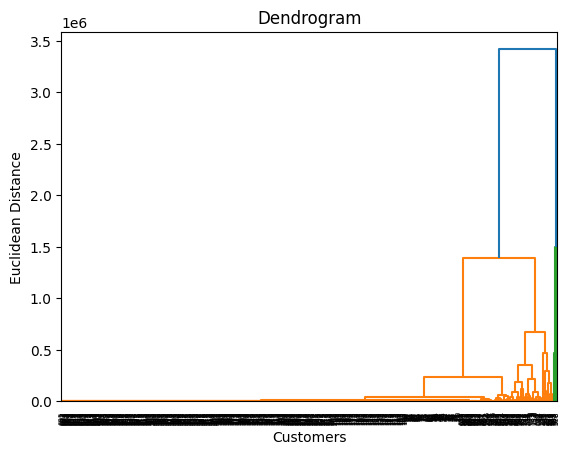

AttributeError: 'NoneType' object has no attribute 'T'

In [110]:
#use dendogram to find optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

In [116]:
# !pip install scikit-learn

In [113]:
#perform hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(X)

C:\Users\Tis\Documents\Test\Projects\Python\DB\dbrockwood\Lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



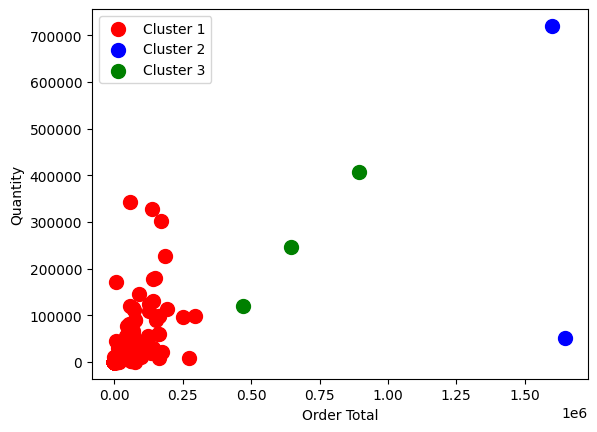

In [115]:
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s=100, c='green', label='Cluster 3')
# plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s=100, c='cyan', label='Cluster 4')
# plt.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s=100, c='magenta', label='Cluster 5')
plt.xlabel('Order Total')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [119]:
cluster_3_indices = np.where(y_hc == 1)
cluster_3_indices

(array([578, 580], dtype=int64),)

### 3.2- Client cohort (behaviour evolution & cust retention) analysis

In [ ]:
# 2- Client Type Analysis: Examine the distribution of new and returning customers. Understand the differences in behavior and spending between these two groups. Determine strategies to retain and engage both types of customers.
# CHURN RATE =  rate of attrition, rate customers stop doing business with a company on given timeframe
# (users at start - users at end) / users at start
# A 5% increase in retention can increase a company’s profits from 25% to up to 95%

In [ ]:
# Define Churn: Begin by clearly defining what "churn" means for your business. Churn can vary from one industry to another. For example, in a subscription-based business, churn might mean customers canceling their subscriptions. In e-commerce, it could mean customers who haven't made a purchase in a certain period.

# Gather Data: Collect and consolidate relevant data. You'll need data on customer interactions, behaviors, and demographics. Common data sources include your customer database, sales records, website analytics, and customer support interactions.

# Create a Cohort: Cohort analysis involves grouping customers based on a shared characteristic or behavior. For churn analysis, you might create cohorts based on sign-up date, first purchase date, or subscription start date.

# Determine the Churn Window: Decide on the time frame you'll use to identify churn. For example, you might consider a customer as churned if they haven't made a purchase in the last 90 days.

# Calculate Churn Rate: Calculate the churn rate for each cohort. Churn rate is typically the number of customers who churned within a specific period divided by the total number of customers in that cohort. It's often expressed as a percentage.

# Identify Patterns: Analyze your data to identify patterns or trends in churn. Look for common characteristics among customers who churned. Are there specific cohorts or customer segments with higher churn rates?

# Feature Engineering: Create new features or metrics that might be indicative of churn. For example, you could calculate the customer's average order value, frequency of purchases, or the time since their last interaction with your business.

# Segmentation: Segment your customer base into groups based on behaviors or characteristics that might be related to churn. Common segments might include high-value customers, long-time customers, or customers who've had recent interactions.

# Hypothesize and Test: Formulate hypotheses about what factors might be driving churn. Test these hypotheses using statistical methods or machine learning models. Common factors to explore include customer satisfaction, product usage, and customer support interactions.

# Predictive Modeling: Build predictive models to identify customers at risk of churning. Machine learning models like logistic regression, decision trees, or random forests can help predict which customers are likely to churn based on historical data.

# Intervention Strategies: Once you've identified high-risk customers, develop intervention strategies to reduce churn. These strategies might include targeted marketing campaigns, personalized offers, or improving the customer experience.

# Monitor and Iterate: Churn analysis is an ongoing process. Continuously monitor the impact of your intervention strategies and iterate on them based on results. Keep refining your analysis to uncover new insights.

# Reporting and Visualization: Communicate your findings and recommendations to relevant stakeholders through reports and visualizations. Tools like dashboards can help in real-time monitoring.

# Feedback Loop: Establish a feedback loop where insights from churn analysis inform product development, marketing strategies, and customer support efforts

In [ ]:
# analyse des client behaviour, tout analyse sur le profit
# comment mesurer la perf en terme de timing


# Client Behaviour with ML classification https://medium.com/the-power-of-ai/classifying-client-behaviour-with-ml-826c621a7b6c 
# PCA aims to reduce the dimensions of features. So to reduce to ideal number of features when they re too numerous use PCA
# Agglomerative hierarchical clustering so dendogram of hierarchy scipy.cluster.hierarchy 
# K means and visualize the impact of these variables on each cluster with the “radar plot”, showing the value of the features for each cluster.

In [ ]:
# Vars to create a develop a scoring mechanism for customers based on their behavior 
# and analyze their purchasing pattern to try and understand product associations to guide in promotions
# https://medium.com/@rohitamanchi/segmentation-and-scoring-of-customers-of-a-retail-client-e8e569b08498
# Unique CustomerID
#  Revenue: Total cost of all transactions per
# CustomerID
#  Quantity: Total number of products bought by each CustomerID
#  Minimum Cost: Minimum cost per CustomerID
#  Maximum Cost: Maximum cost per CustomerID
#  Frequency: Total number of visits per CustomerID
#  Recency: Number of days between each Customer ID’s last visitand 31–12 2016.
#  Tenure: Number of days between each Customer ID’s last visit and first visit.

In [129]:
df.head(2)

Quote status                     Name (from Customer)  Order num Order status  Order total  Total paid  Balance due Sales Rep (from Customer)  Quantity (from Order items) Num (from Customer)          Clean Date  Cost total    Month Bottle Type  Number of Purchases  Amount Unpaid  Average Purchase Amount                                       Project name      Types  Unit price $ (from Order items)    Item description (from Order items)           Order date   Date quote created Date quote accepted  Days Since Last Transaction  Days Between Last Two Transactions  Churn  Days since last order  Recency  Frequency    Monetary  R  F  M  RFM Score             Segment                                   Segment Behavior                         Segment Potential Strategy
0  Feedback pending  Stellar Spirits   Wines Inc   Comisario        0.0         None          0.0         0.0          0.0     ['recqmM88sOdhTM8jg']                          0.0                   0 2023-10-23 09:22:18         0.0  2023-10         N/A                   17            0.0                  2270.59  Comisario glass bottle, 700 ml with medallion ...         []                              0.0                                     []  2023-10-23 00:00:00  2023-10-23 00:00:00                 NaT                          NaN                                 NaN      1                      2        2          1        0.00  5  5  1        551  Potential Loyalist  They recently spent a fair amount of money on ...  Invite them to join a loyalty program or to ge...
1          Accepted                      Aiko Importers  Inc    29700.0         None     274176.0         0.0     274176.0     ['recf7VFVFSeyapEr0']                       7680.0                  10 2023-07-24 05:19:13         0.0  2023-07       Glass                   31      -274176.0                 55845.97                          UK 700ml Dragon with baby  ['Glass']                             35.7  ['Glass - UK 700ml Dragon with baby']  2023-07-24 00:00:00                    0                 NaT                          NaN                                 NaN      1                     93        8         28  1676325.12  5  5  5        555            Champion  Completed a recent purchase. They buy frequent...  Reward them. Can be early adopters of new prod...

#### 3.2.1 - global churn rate

In [ ]:
df['Bottle Type'].value_counts()

In [ ]:
import pandas as pd

# Assuming 'df' is your DataFrame
# Convert 'Clean Data' to datetime if it's not already in datetime format
df['Clean Date'] = pd.to_datetime(df['Clean Date'])

# Filter the data for each bottle type
ceramic_df = df[df['Bottle Type'] == 'Ceramic']
glass_df = df[df['Bottle Type'] == 'Glass']
perfume_df = df[df['Bottle Type'] == 'Perfume']

# Calculate churn rate for each bottle type
def calculate_churn_rate(df):
    # Group by customer and find their first and last purchase dates
    customer_first_purchase = df.groupby('Num (from Customer)')['Clean Date'].min()
    customer_last_purchase = df.groupby('Num (from Customer)')['Clean Date'].max()

    # Calculate churn rate
    churned_customers = (customer_last_purchase - customer_first_purchase).dt.days <= 30  # Assuming a 30-day churn period
    churn_rate = churned_customers.sum() / len(df['Num (from Customer)'].unique())

    return churn_rate

ceramic_churn_rate = calculate_churn_rate(ceramic_df)
glass_churn_rate = calculate_churn_rate(glass_df)
perfume_churn_rate = calculate_churn_rate(perfume_df)

print("Churn Rate for Ceramic Bottles:", ceramic_churn_rate)
print("Churn Rate for Glass Bottles:", glass_churn_rate)
print("Churn Rate for Perfume Bottles:", perfume_churn_rate)
print("High churn rate indicates a significant loss of customers for that specific product category, aim to lower churn rates to retain customers and encourage repeat purchases.")
print("In other words, every customer who bought that bottle type did not make a repeat purchase during or after the churn period.")
print("Reasons : 1 Dissatisfaction with the product quality or experience. 2 Lack of product variety or innovation. 3 Pricing issues. 4 Competing offers or alternatives in the market.")

In [ ]:
#define cohort such as Group customers based on the date they registered or signed up.
#Group your customers into cohorts based on the chosen criterion. 
#For example, if you select Purchase Frequency Cohorts:
#or Purchase Value Cohorts:

In [ ]:
#create churn column based on calculating when was last transaction
# Convert 'Clean Date' column to datetime
df['Clean Date'] = pd.to_datetime(df['Clean Date'])

# Sort DataFrame by customer and date
df.sort_values(by=['Num (from Customer)', 'Clean Date'], inplace=True)

# Drop duplicates based on 'Order num' and keep the latest row
df = df.drop_duplicates(subset=['Num (from Customer)', 'Order num'], keep='last')

# Calculate days since last transaction and days between last and previous-to-last transaction
df['Days Since Last Transaction'] = df.groupby('Num (from Customer)')['Clean Date'].diff().dt.days
df['Days Between Last Two Transactions'] = df.groupby('Num (from Customer)')['Clean Date'].diff(periods=2).dt.days


In [ ]:
df[36:39]

In [ ]:
df['Days Since Last Transaction'].value_counts()

In [ ]:
df['Days Between Last Two Transactions'].value_counts()

In [ ]:
# Create 'Churn' column based on conditions
df['Churn'] = np.where(
    (df['Days Since Last Transaction'] > 30) | 
    (df['Days Between Last Two Transactions'] > 30) |
    (pd.isna(df['Days Since Last Transaction']) | pd.isna(df['Days Between Last Two Transactions'])),
    1,
    0
)


In [ ]:
df['Churn'].value_counts(normalize=True)

In [ ]:
df.sample(2)

#### Univariate analysis towards Churn

In [ ]:
df_copy = df[['Name (from Customer)','Num (from Customer)','Order num','Clean Date',
              'Order total','Total paid','Balance due', 
            'Quantity (from Order items)','Unit price $ (from Order items)','Project name (from Orders)','Project name',
              'Bottle Type',
             'Quote status', 'Order status','Balance due quartile desc','Number of Purchases',
              'Segment', 'RFM Score','Segment Behavior','Segment Potential Strategy',
              'Status (from Customer)','Client Type','Average Purchase Amount','Churn','Days since last order', 
              'Country','City',
            'Supplier (from Order items)','Sales Rep (from Customer)','Special discount','Commission'
            ]]

In [ ]:
df_copy.info()

In [ ]:
for i, variable in enumerate(df_copy.drop(columns = ['Churn', 'Name (from Customer)','Num (from Customer)',
                                                     'Order num','Clean Date','Project name (from Orders)',
                                                     'Project name','Supplier (from Order items)','Special discount',
                                                     'Commission','City',
                                                    'Segment Behavior','Segment Potential Strategy'])):
    plt.figure(i)
    sns.countplot(data = df_copy, x = variable, hue = 'Churn')

In [ ]:
#dummy categorical columns 
df_copy_dummies = pd.get_dummies(df_copy.drop(columns = ['Name (from Customer)','Num (from Customer)',
                                                     'Order num','Clean Date','Project name (from Orders)',
                                                     'Project name','Supplier (from Order items)','Special discount',
                                                     'Commission','City',
                                                    'Segment Behavior','Segment Potential Strategy']))
df_copy_dummies.head()

In [ ]:
#correlation of all parameters to churn
plt.figure(figsize=(8, 12))
correlation = df_copy_dummies.corr()["Churn"].sort_values(ascending=False)
sns.barplot(y=correlation.index, x=correlation.values)
plt.show()

HIGH Churn seen in case of Month to month contracts, No online security, No Tech support, First year of subscription and Fibre Optics Internet

LOW Churn is seens in case of Long term contracts, Subscriptions without internet service and The customers engaged for 5+ years

Factors like Gender, Availability of PhoneService and # of multiple lines have alomost NO impact on Churn

This is also evident from the Heatmap below.

In [ ]:
#coorelation heatmap
plt.figure(figsize=(12,12)) 
sns.heatmap(df_copy_dummies.corr(), cmap='coolwarm')

As we are more intrested in the Churners I am going to analyse the churners with related to different insides we get from above analaysis on the paramters where the churnner are heigh 

In [ ]:
#Creating new data Frame for churnners and not churnners
new_df_target0 = df_copy.loc[df_copy["Churn"] ==0]
new_df_target1 = df_copy.loc[df_copy['Churn'] == 1]

In [ ]:
# defining function to plot 
def uniplot(df, col, title, hue = None):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 15
    plt.rcParams['axes.titlepad'] = 20
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 4 + 2*len(temp.unique())
    fig.set_size_inches(width , 6)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,palette='bright') 
        
    plt.show()

In [ ]:
uniplot(new_df_target1,col = 'Sales Rep (from Customer)', title = 'Distribution of Sales Rep for Churned Customers', hue = 'Bottle Type')

In [ ]:
uniplot(new_df_target1,col = 'Name (from Customer)', title = 'Distribution of Sales Rep for Churned Customers', hue = 'Bottle Type')

Insights
Electronic Check Medium: It's noteworthy that customers using electronic check as their payment medium tend to have the highest churn rates. This suggests that there might be issues or concerns related to the electronic check payment method that could be contributing to churn.

Contract Type - Monthly Customers: Customers on a monthly contract basis are more likely to churn. This could be attributed to the absence of long-term commitments, as they have the flexibility to switch providers without contractual obligations.

No Online Security, No Tech Support: Customers without online security and tech support features tend to exhibit higher churn rates. This indicates the importance of these services in retaining customers, as their absence may lead to dissatisfaction and attrition.

Non-Senior Citizens: It's interesting to observe that non-senior citizens are more likely to churn. This demographic insight can inform targeted retention strategies to better cater to the needs and preferences of different age groups.

#### Feature analysis

In [ ]:
#Normalize Data
from sklearn.preprocessing import StandardScaler

#Conert Categorical to Numerical Value
from sklearn.preprocessing import LabelEncoder

#Columns Relationship for target value
from sklearn.feature_selection import mutual_info_classif,SelectKBest,f_classif

#Splitting Data
from sklearn.model_selection import train_test_split,cross_val_score

#PCA
from sklearn.decomposition import PCA

#Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#Metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_curve,auc

In [ ]:
#convert categorical
le = LabelEncoder()
Label = df.select_dtypes(include=["object"])
df1 = df.copy()

for i in Label:
  df1[i] = le.fit_transform(df1[i])

df1.shape

In [ ]:
df1.dtypes

In [ ]:
df1.head()

In [ ]:
X = df1.iloc[:,1:20]
Y = df1.iloc[:,-1]

In [ ]:
### Feature engineering : mutual information

In [ ]:
mi_score1 = mutual_info_classif(X,Y)
mi_score1 = pd.Series(mi_score1)
mi_score1.index = X.columns
mi_score1.sort_values(ascending=True)

In [ ]:
mi_score1.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [ ]:
# split train test 
train_data,test_data,train_label,test_label = train_test_split(X,Y,test_size=0.3, random_state=0)
print("train_data : ",train_data.shape)
print("train_label : ",train_label.shape)
print("test_data : ",test_data.shape)
print("test_label : ",test_label.shape)

In [ ]:
#normalize data
sc = StandardScaler()
train_data_sc = sc.fit_transform(train_data)
test_data_sc = sc.fit_transform(test_data)

In [ ]:
train_data_sc

In [ ]:
# PCA

In [ ]:
pc = PCA()
train_data_sc_pc = pc.fit_transform(train_data_sc)
test_data_sc_pc = pc.fit_transform(test_data_sc)

In [ ]:
# Variance ratios nikalen
explained_variance = pc.explained_variance_ratio_

In [ ]:
# Principal components ki importance ko dekhen
print("Explained Variance Ratios:", explained_variance)

In [ ]:
# calculate cumulative sum of explained variance ratio
cumulative_variance = np.cumsum(explained_variance)


# plot the scree plot or cumulative explained variance plot
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot or Cumulative Explained Variance Plot')
plt.grid(True)
plt.show()

In [ ]:
# Cumulative explained variance nikalen
cumulative_variance = np.cumsum(explained_variance)

# Kitne components select karna hai, yeh decide karen
desired_variance = 0.95  # Example: 95% variance ko capture karna hai

# Kitne components select kiye ja sakte hain
num_components = np.argmax(cumulative_variance >= desired_variance) + 1

print(f"\nNumber of components selected: {num_components}")
     

In [ ]:

train_data_sc_pc_select = train_data_sc_pc[:, :num_components]
test_data_sc_pc_select = test_data_sc_pc[:, :num_components]

In [ ]:
print("train_data : ",train_data_sc_pc_select.shape)
print("test_data : ",test_data_sc_pc_select.shape)

### analyzing features based on churn

#### 3.2.2- Cohort criteria based on product type / purchase frequency / purchase value

In [ ]:
#USER INPUT IN DATA VIZ
# Define cohort criteria
cohort_frequency = ['Y','M','W'][1]
cohort_value_labels = ['Low', 'Medium', 'High']
cohort_product_labels = df['Bottle Type'].unique()
cohort_product=cohort_product_labels[1]

In [ ]:
cohort_product

In [ ]:
# Calculate purchase frequency (monthly)
df['Clean Date'] = pd.to_datetime(df['Clean Date'])
df['Month'] = df['Clean Date'].dt.to_period(cohort_frequency)
purchase_frequency = df.groupby('Num (from Customer)')['Month'].nunique()


In [ ]:
# Calculate purchase value segments (High, Medium, Low)
df['Cohort Value'] = pd.qcut(df['Invoice total'], q=3, labels=False, duplicates='drop')

In [ ]:
# Assign cohorts based on criteria
df['Cohort'] = (
    df['Bottle Type'].astype(str) + ' ' +
    df['Cohort Value'].astype(str) + ' ' +
    cohort_product
)

In [ ]:
cohorts = df[['Num (from Customer)', 'Cohort']]
cohorts.head()

#### 3.2.3 -  churn rate for each cohort

In [ ]:
# WHAT ARE THE FACTORS THAT CONTRIBUTE TO CHURN RATE ; CUST EXPERIENCE? PRICING?  lack of product innovation, competitive offerings, pricing discrepancies, and ineffective onboarding processes 

In [ ]:
#algorithm that predicts the probability of a customer churning based on certain factors

In [ ]:
#choice of factor : https://learnpython.com/blog/python-customer-churn-prediction/


In [ ]:
df.sample(2)

In [ ]:
#create the variables X
df['Order status'].value_counts()

In [ ]:
df['Client Type'].value_counts()

In [ ]:
df['Average Purchase Amount'].describe()

In [ ]:
df['Bottle Type'].value_counts()

#### 3.3 - Modelling, predicting churn

In [ ]:
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN

In [ ]:
df_copy_dummies.head()

In [ ]:
# Creating X and Y variable
df_copy_dummies.dropna(how = 'any', inplace = True)
x = df_copy_dummies.drop('Churn', axis =1)
x
 

In [ ]:
y = df_copy_dummies['Churn']
y

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)

#### 3.4.1 Decision tree classifier

In [ ]:
model_dt = DecisionTreeClassifier(criterion = 'gini', random_state = 100, max_depth = 6, min_samples_leaf =8)

In [ ]:
model_dt.fit(x_train, y_train)

In [ ]:
y_pred = model_dt.predict(x_test)
y_pred

In [ ]:
model_dt.score(x_train, y_train)

In [ ]:
print(classification_report(y_test, y_pred, labels = [0,1]))

In [ ]:
print(confusion_matrix(y_test, y_pred))

When building a model, it's essential to address the issue of class imbalance, as our dataset exhibits an imbalance with a ratio of 73:27. While the overall accuracy may seem good at 75%, the model's performance is not considered satisfactory. The minority class, which represents 1 and typically has a low precision score, needs special attention.

To tackle the class imbalance, we will employ over-sampling and under-sampling techniques in our model-building process. By addressing this imbalance, we aim to improve the model's ability to correctly classify the minority class and enhance overall performance

In [ ]:
#if need to address imbalance, smote enn 

#### 3.4.2 Random Forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model_rf = RandomForestClassifier(n_estimators = 100 ,criterion = 'gini', random_state = 100, max_depth = 6, min_samples_leaf =8)

In [ ]:
model_rf.fit(x_train, y_train)

In [ ]:
pred_rf = model_rf.predict(x_test)

In [ ]:
model_rf.score(x_train, y_train)

In [ ]:
print(classification_report(y_test, pred_rf, labels = [0,1]))

In [ ]:
dft = pd.DataFrame({'Actual': y_test, 'Predicted': pred_rf})
ax = sns.distplot(dft['Actual'], color = 'blue', hist = False, kde = True, kde_kws = {'linewidth': 3}, label = 'Actual');
sns.distplot(dft['Predicted'], color = 'red', ax=ax, hist = False, kde = True, kde_kws = {'linewidth': 3}, label = 'Predicted');

#### MOdel

In [141]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, recall_score, f1_score, roc_auc_score, precision_score, RocCurveDisplay
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


ModuleNotFoundError: No module named 'lightgbm'

In [142]:
# Base model(without scaling)

models = [("LR", LogisticRegression()),
         ("KNN", KNeighborsClassifier()),
         ("CART", DecisionTreeClassifier()),
         ("RF", RandomForestClassifier()),
         ("GBM", GradientBoostingClassifier()),
         ("XGB", XGBClassifier()),
         ("LGBM", LGBMClassifier(verbose=-1)),
         ("ADA", AdaBoostClassifier()),
         ("CatBoost", CatBoostClassifier(verbose=False))
          ]
transformer = ColumnTransformer([("OHE", OneHotEncoder(drop="if_binary"), ohe_cols)], 
                                remainder="passthrough")

X = df.drop([target, "customerID"], axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=44)

for name, model in models:
    
    pipe = Pipeline([("transformer", transformer),
                    ("model", model)])
    
    y_pred = pipe.fit(X_train, y_train).predict(X_test)
    
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_result = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")
    
    print(f"{name} Recall -> {cv_result.mean()}\n")

NameError: name 'LogisticRegression' is not defined

In [143]:
# Model with scaling 

In [ ]:
# With Scaling

X = df.drop([target, "customerID"], axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=44)

transformer = ColumnTransformer([("OHE", OneHotEncoder(drop="if_binary"), ohe_cols),
                                ("Scaler", MinMaxScaler(), num_cols)], 
                                remainder="passthrough")

for name, model in models:
    
    pipe = Pipeline([("transformer", transformer),
                    ("model", model)])
    
    y_pred = pipe.fit(X_train, y_train).predict(X_test)
    
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_result = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")
    
    print(f"{name} Recall with scaled -> {cv_result.mean()}\n")

## 4- Sales rep analysis

In [ ]:
# 4- Sales Rep Analysis: Analyze the performance of sales representatives. Calculate metrics like total sales, average purchase amount, and customer satisfaction scores. Identify top-performing sales reps and areas for improvement.
#which action drives retention?
# cohort analysis retention table lets you see exactly which customers leave and when, but also understand why.

In [ ]:
# 5- Payment Lateness Analysis: You mentioned earlier that you want to analyze payment lateness. You can calculate the payment delay for each transaction (the difference between the due date and payment date), identify trends in payment delays, and potentially segment customers based on their payment behaviors.


In [ ]:
# 6- Predictive Modeling: If you have historical data, consider building predictive models. For example, you can predict customer churn, forecast future sales, or estimate customer lifetime value (CLV) based on historical purchase data.
# product recommendation? https://github.com/gitakartika/customer-segmentation-analysis-product-recommender-system/blob/master/Customer%20Segmentation%20Analysis%20and%20Product%20Recommender%20System.ipynb

In [ ]:
# 7- Hypothesis Testing: If you have specific questions or hypotheses, conduct hypothesis tests to validate your assumptions or draw statistically significant conclusions.


In [ ]:
# import dtale
# d = dtale.show(df)
# d.open_browser()

In [ ]:
# from dataprep.eda import create_report
# create_report(df)

In [ ]:
# from autoviz import AutoViz_Class
# AV = AutoViz_Class()
# #with a target variable
# target_variable = "Quote status"
# filename = "data.csv"
# dft = AV.AutoViz(
#     filename,
#     sep=",",
#     depVar=target_variable,
#     dfte=None,
#     header=0,
#     verbose=1,
#     lowess=False,
#     chart_format="svg",
#     max_rows_analyzed=150000,
#     max_cols_analyzed=30,
#     save_plot_dir=None
# )

In [ ]:
# !pip install sweetviz

In [ ]:
import sweetviz
my_report  = sweetviz.analyze([df,'Sales Rep (from Customer)'], target_feat='Quote status')
my_report.show_html('FinalReport.html')

## 5- querying with llama

In [ ]:
from llama_index.query_engine import PandasQueryEngine
query_engine = PandasQueryEngine(df=df, verbose=True)

In [ ]:
response = query_engine.query(
    "What is the correlation between survival and age?",
)

In [ ]:
response

In [ ]:
# get pandas python instructions
print(response.metadata["pandas_instruction_str"])